# Searching for QPOs in Comet data.

We have some comet data, and we're looking for a period. 
Let's first load some packages.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style("whitegrid")
sns.set_palette('colorblind')

cdata = "black"
cmodel = "red"

import numpy as np
import pandas as pd

from stingray import Lightcurve
from stingray import Powerspectrum

from stingray.pulse import z2_n_probability, z2_n_detection_level, z_n

import george

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:20: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


We have to load the data. It's in ASCII files, but I need to do some data wrangling, so let's load them in pandas DataFrames instead:

Combined APO and DCT Data set:

In [76]:
apo_dct = pd.read_csv("comet/APO_DCT_A2017U1_2017_10_30_date_mjd_mag_r_mag_unc_obs_code.txt", sep=" ", 
                  names=["time", "mag", "mag_err", "ObsID"])

<IPython.core.display.Javascript object>


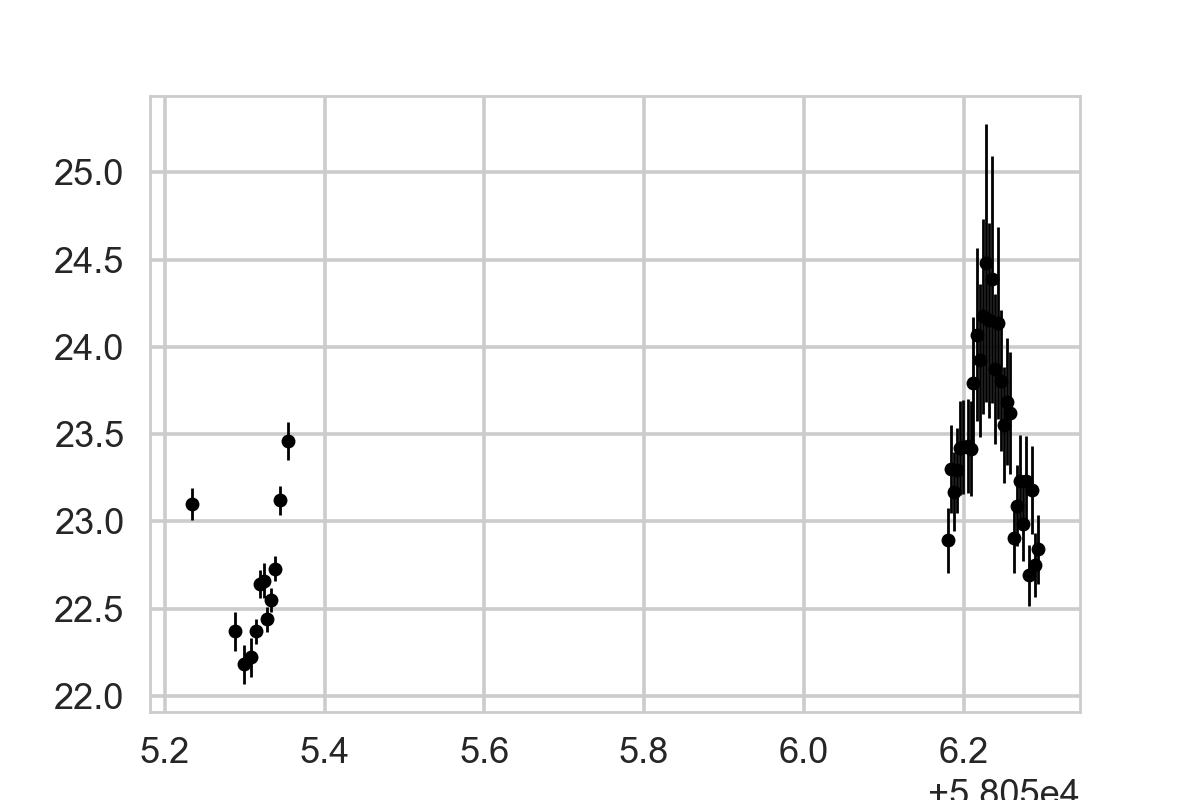

<Container object of 3 artists>

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.errorbar(apo_dct.time, apo_dct.mag, yerr=apo_dct.mag_err, color="black", fmt="o", 
            markersize=5, linewidth=1)

In [87]:
data = apo_dct

## Fitting a Pure Sinusoid

Let's start with the simplest model: a pure sinusoidal model.

We'll define a Gaussian likelihood for the signal:

In [88]:
class GaussLikelihood(object):
    
    def __init__(self, x, y, yerr, model):
        self.x = x
        self.y = y
        self.yerr = yerr
        self.model = model
        
    def evaluate(self, pars, neg=False):

        mean_model = self.model(self.x, *pars)

        loglike = np.sum(-0.5*np.log(2.*np.pi) - np.log(self.yerr) -
                         (self.y-mean_model)**2/(2.*self.yerr**2))

        if not np.isfinite(loglike):
            loglike = -np.inf

        if neg:
            return -loglike
        else:
            return loglike
        
    def __call__(self, parameters, neg=False):
        return self.evaluate(parameters, neg)
        

Now we can set up the sinusoidal model:

In [89]:
def sinusoid(t, logamp, period, phase, bkg):
    """
    A sinusoidal model.
    
    Parameters
    ----------
    t : iterable
        The dependent coordinate
        
    logamp : float
        The logarithm of the sinusoidal amplitude
        
    period : float
        The period of the sinusoid
        
    phase : float [0, 2*pi]
        The phase of the sinusoidal signal
        
    bkg : float
        The mean magnitude
    
    Returns
    -------
    res : numpy.ndarray
        The result
    """
    res = np.exp(logamp) * np.sin(2.*np.pi*t/period + phase) + bkg
    return res

Does this work?

In [90]:
time = np.array(data["time"])
mag = np.array(data["mag"])
mag_err = np.array(data["mag_err"])

In [91]:
period = 4.0/24
amp = 1
bkg = 23.0
phase = np.pi

test_m = sinusoid(time, amp, period, 2*phase, bkg)


<IPython.core.display.Javascript object>


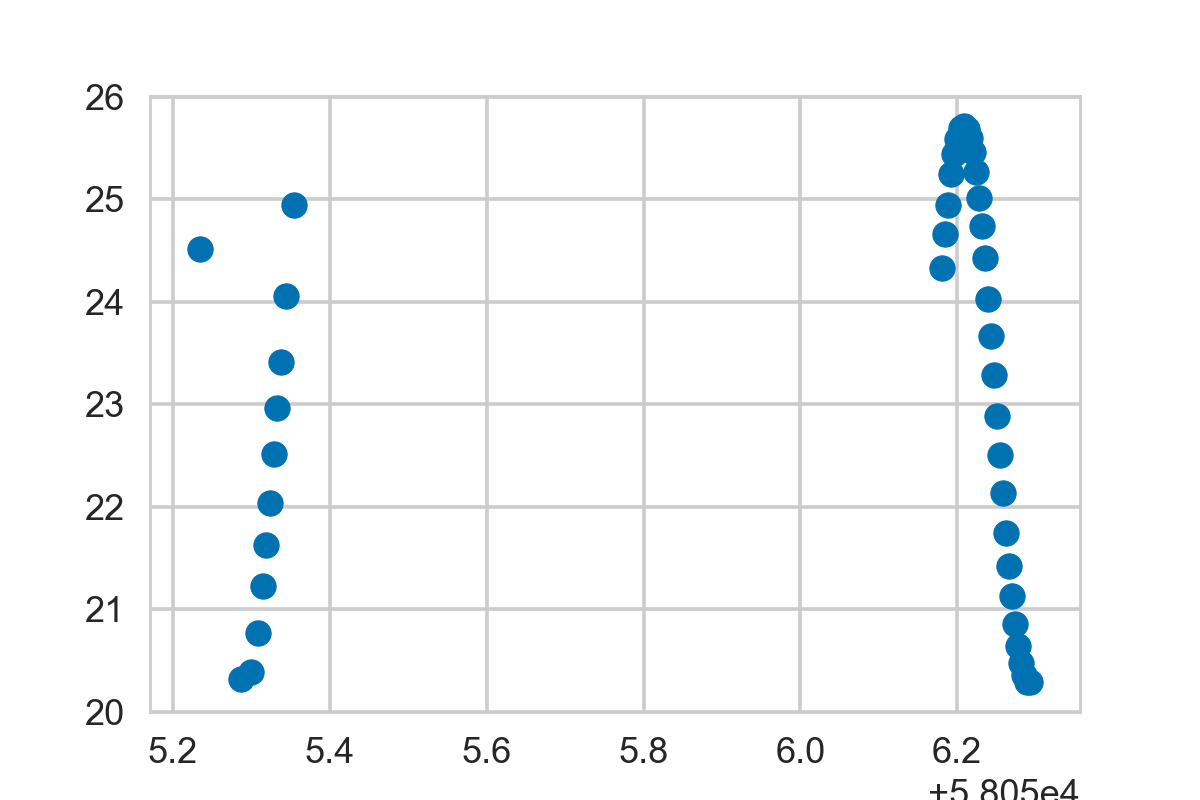

In [92]:
plt.figure(figsize=(6,4))
plt.scatter(time, test_m)

Okay, that looks about right. Let's compute the log-likelihood:

In [93]:
loglike = GaussLikelihood(time, mag, mag_err, sinusoid)

In [94]:
test_pars = [np.log(amp), period, phase, bkg]

In [95]:
loglike(test_pars, neg=True)

950.85005390654385

Awesome, now let's define a Posterior so we can actually do MCMC:

In [96]:
import scipy.stats

In [97]:
vm = scipy.stats.vonmises(kappa=0.2)

In [98]:
class GaussPosterior(object):
    
    def __init__(self, x, y, yerr, model):
        self.x = x
        self.y = y
        self.yerr = yerr
        self.model = model
        
        self.loglikelihood = GaussLikelihood(x, y, yerr, model)
        #self.vm = scipy.stats.vonmises(kappa=0.2, loc=0.0)
        self.flat_prior = np.log(1/20.0) + np.log(1/(1 - 1/24.0)) + \
                          np.log(1/5.0) + np.log(1/(2.*np.pi))
        
    def logprior(self, pars):
        logamp = pars[0]
        period = pars[1]
        phase = pars[2]
        bkg = pars[3]
        
        if logamp < -20 or logamp > 20:
            return -np.inf
        elif period < 1/24.0 or period > 1.0:
            return -np.inf
        elif bkg < 20 or bkg > 25:
            return -np.inf 
        elif phase < 0 or phase > 2.*np.pi:
            return -np.inf
        else:
            return self.flat_prior
        
    def logposterior(self, pars, neg=False):
        lpost = self.logprior(pars) + self.loglikelihood(pars, neg=False)
        
        if not np.isfinite(lpost):
            lpost = -np.inf
            
        if neg:
            return -lpost
        else:
            return lpost
        
    def __call__(self, pars, neg=False):
        return self.logposterior(pars, neg)

Okay, cool, we've assumed some reasonable priors for the problem, now let's see whether that works:

In [99]:
lpost = GaussPosterior(time, mag, mag_err, sinusoid)

In [100]:
lpost(test_pars)

-957.25054154452243

Let's make sure the priors all work correctly:

In [101]:
# should not pass, amplitude out of range:
test_pars = [-21, period, phase, bkg]
print(lpost(test_pars))

# should not pass, amplitude out of range:
test_pars = [30, period, phase, bkg]
print(lpost(test_pars))

-inf
-inf


In [102]:
##### should not pass, period out of range:
test_pars = [np.log(amp), 0.5/24, phase, bkg]
print(lpost(test_pars))
##### should not pass, period out of range:
test_pars = [np.log(amp), 25/24, phase, bkg]
print(lpost(test_pars))

-inf
-inf


In [103]:
##### should not pass, phase out of range:
test_pars = [np.log(amp), period, -0.1, bkg]
print(lpost(test_pars))
##### should not pass, phase out of range:
test_pars = [np.log(amp), period, 2.1*np.pi, bkg]
print(lpost(test_pars))

-inf
-inf


In [104]:
##### should not pass, bkg out of range:
test_pars = [np.log(amp), period, phase, 19]
print(lpost(test_pars))
##### should not pass, bkg out of range:
test_pars = [np.log(amp), period, phase, 25.2]
print(lpost(test_pars))

-inf
-inf


Okay, that seems to work correctly, I think. I'm going to test the above on some simulated data, just to be sure I do the right thing:

In [105]:
logamp = 0.0
period = 4/24.0
phase = 1.2
bkg = 23.0

fake_pars = [logamp, period, phase, bkg]

mag_model = sinusoid(time, logamp, period, phase, bkg)
fake_mag = mag_model + np.random.normal(loc=0.0, scale=mag_err)

<IPython.core.display.Javascript object>


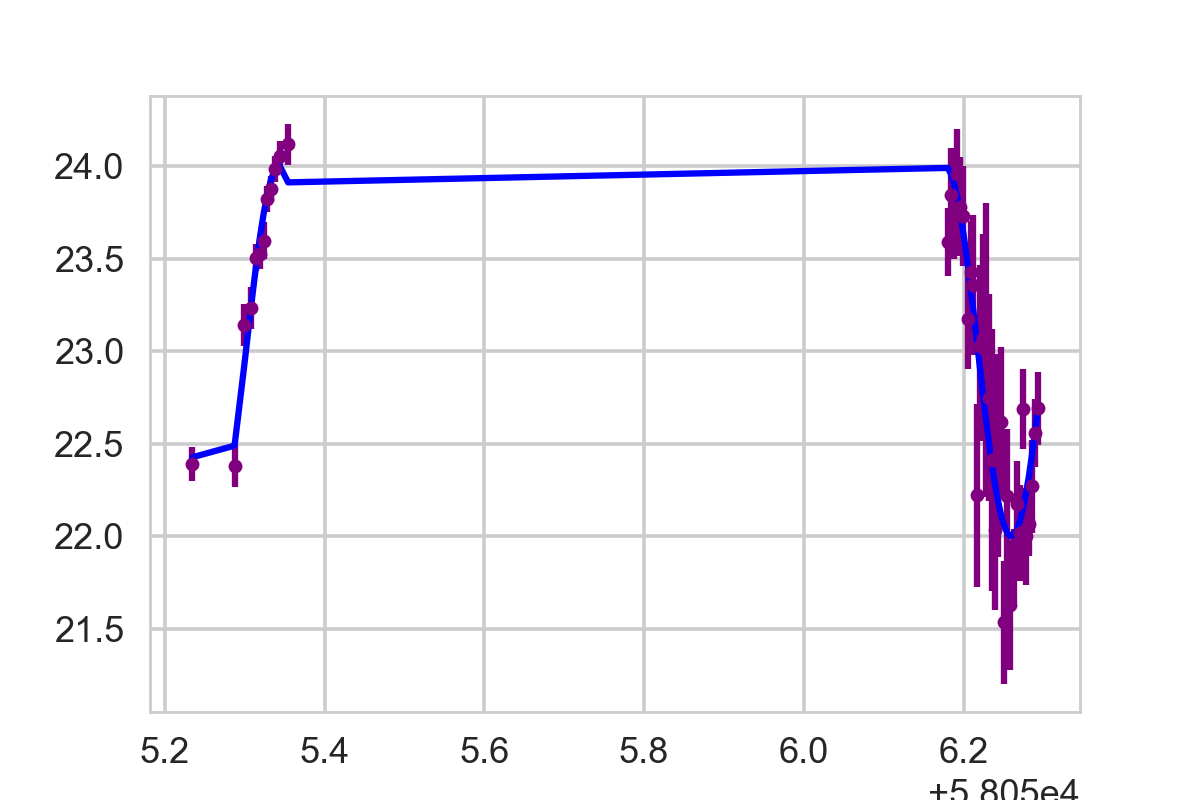

In [106]:
plt.figure(figsize=(6,4))

plt.errorbar(time, fake_mag, yerr=mag_err, fmt="o", markersize=5, color="purple")
plt.plot(time, mag_model, color="blue")

Okay, let's do some optimization on that:

In [44]:
import scipy.optimize as op

In [45]:
fake_lpost = GaussPosterior(time, fake_mag, mag_err, sinusoid)

In [46]:
true_pars = [logamp, period, phase, bkg]

In [47]:
lpost(true_pars)

-1080.5410413936013

In [48]:
test_pars = [logamp, period+0.1, phase, bkg]
lpost(test_pars)

-491.18570844065772

In [49]:
start_pars = [-0.1, 4/24.0, phase, 23.5]

res = op.minimize(fake_lpost, start_pars, args=(True), method="powell")

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [50]:
res.x

array([ -0.06047845,   0.16675761,   0.95441859,  23.05518435])

<IPython.core.display.Javascript object>


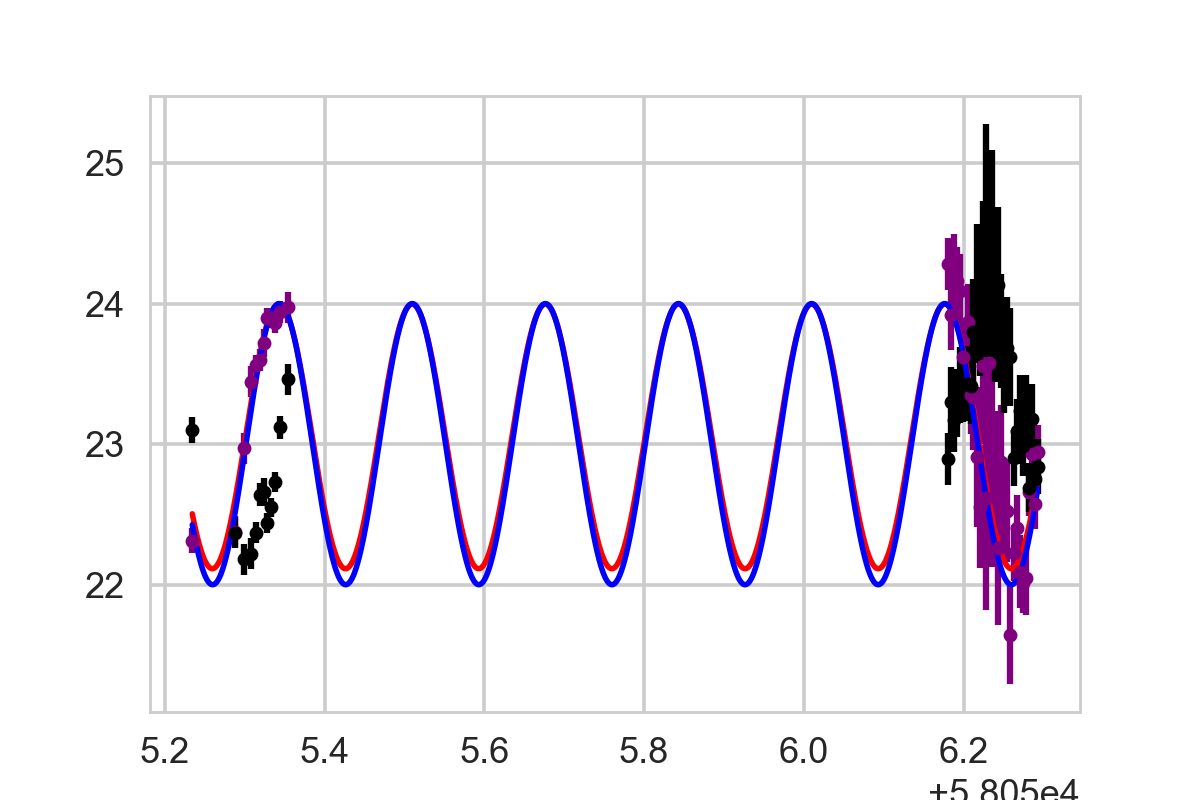

In [51]:
model_time = np.linspace(time[0], time[-1], 2000)
m = sinusoid(model_time, *res.x)
input_m = sinusoid(model_time, logamp, period, phase, bkg)

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.errorbar(time, fake_mag, yerr=mag_err, fmt="o", markersize=5, color="purple", label="data")
ax.errorbar(time, mag, yerr=mag_err, fmt="o", markersize=5, color="black", label="data")

ax.plot(model_time, m, color="red", lw=2, label="best-fit model")
ax.plot(model_time, input_m, color="blue", lw=2, label="original model")

OKay, let's see how MCMC works on my simulated data:

In [52]:
import emcee

In [54]:
# Set up the sampler.
nwalkers, ndim = 200, len(res.x)
sampler = emcee.EnsembleSampler(nwalkers, ndim, fake_lpost, threads=4)

# Initialize the walkers.
p0 = res.x + 0.001 * np.random.randn(nwalkers, ndim)

for p in p0:
    print(fake_lpost(p))

-1576.72588228
-2054.92356368
-2120.86911984
-186.899450035
-469.699404245
-105.751296449
-626.941489227
-12.9183258345
-887.373297894
-1082.83862609
-1858.69076147
-532.058246576
-571.539349622
-955.807367831
-6.58628814645
-26.3539549363
-199.414516741
-24.3799993403
-674.236482301
-69.5465397338
-21.0499429559
-952.435819193
-698.705916174
-817.505456254
-1141.7327741
-145.840698572
-79.6489968473
-1940.12241784
-1718.45381155
-61.6143351936
-769.767502653
-935.565754532
-1768.573979
-415.01678991
-145.140279132
-1457.7859512
-2063.52586168
-1740.45633771
-391.720676691
-739.864663695
-1744.34051761
-220.772615492
-2272.90172451
-44.983455243
-5.94953504155
-2240.59748301
-1039.51164663
-1885.70857637
-120.647097461
-167.283078705
-1170.72047986
-2208.14806266
-12.4512989614
-19.6756813208
-43.1567575617
-166.711279413
-683.727751418
-499.229734442
-27.3494202059
-881.186186556
-2274.91407995
-1418.5870074
-1940.13040176
-1513.25517347
-8.21472614851
-11.4399113757
-680.245294799
-1

In [53]:
print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 10000)

Running burn-in


<IPython.core.display.Javascript object>


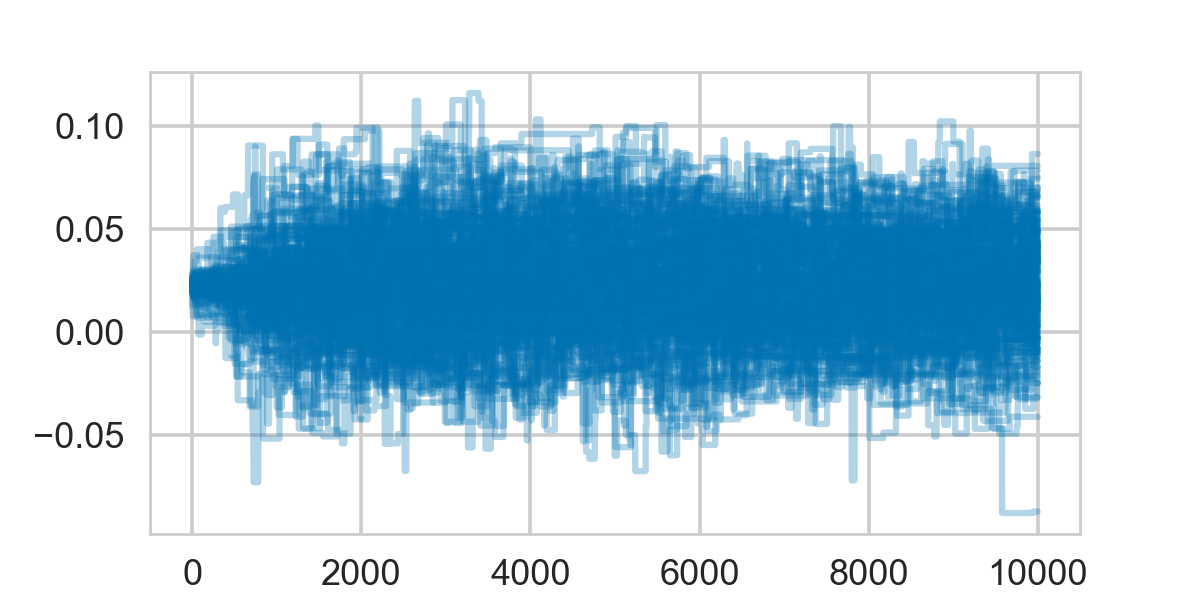

<IPython.core.display.Javascript object>


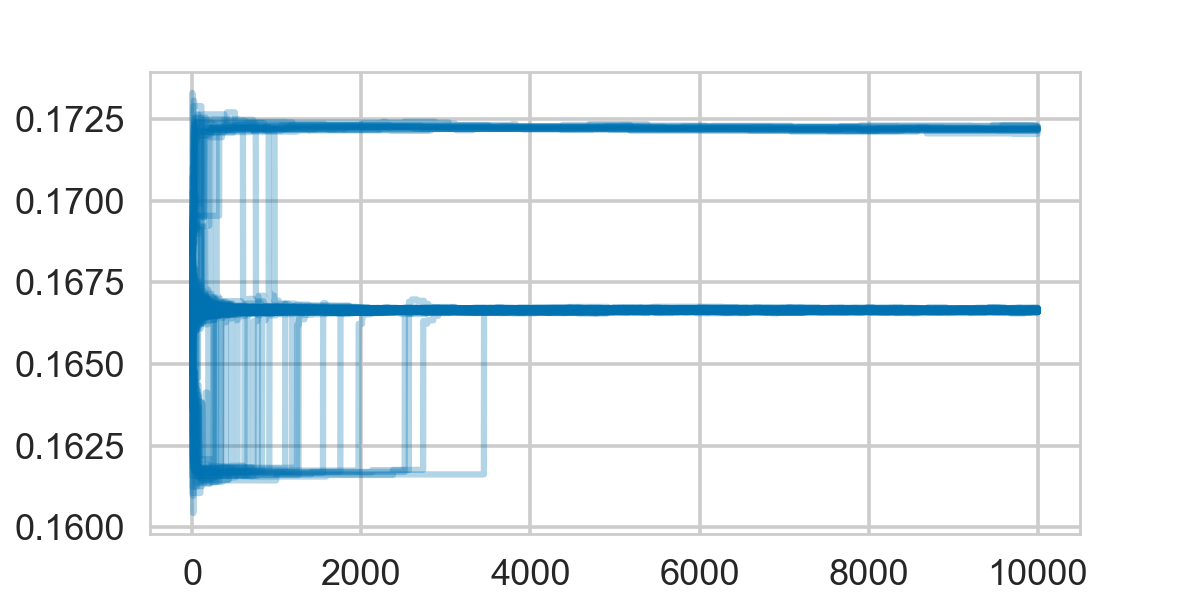

<IPython.core.display.Javascript object>


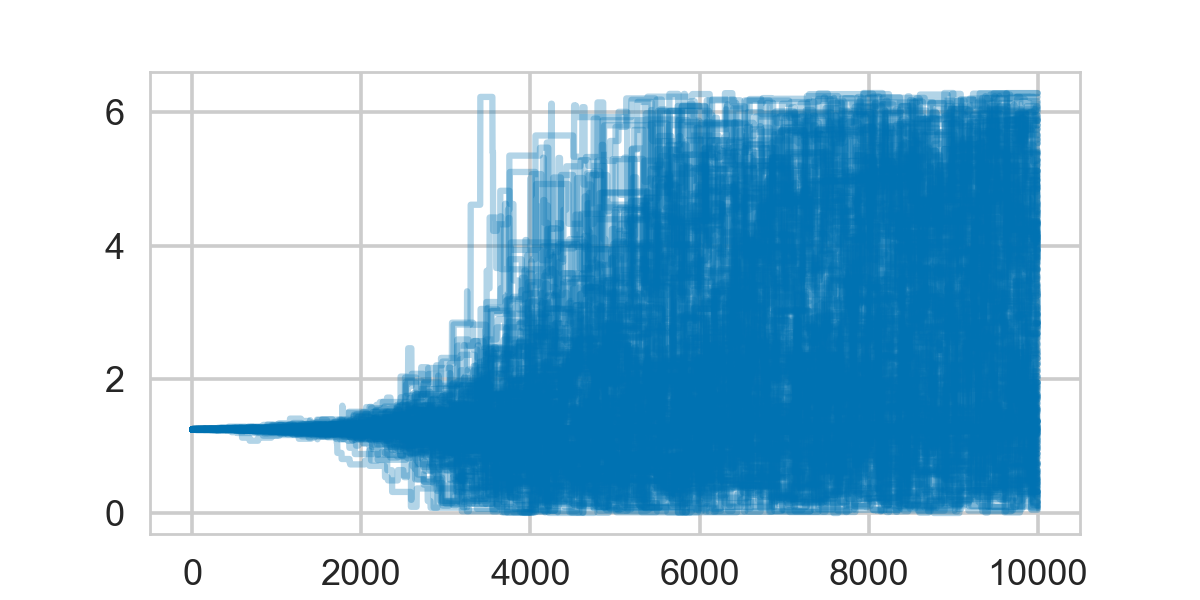

<IPython.core.display.Javascript object>


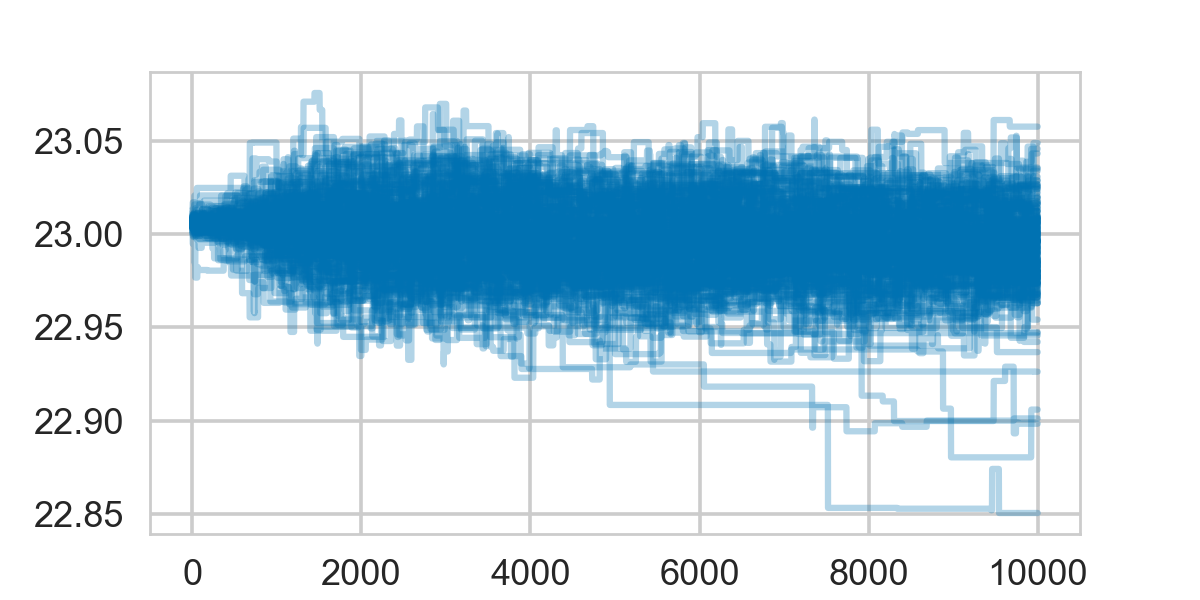

In [54]:
for i in range(ndim):
    fig, ax = plt.subplots(1, 1, figsize=(6,3))
    ax.plot(sampler.chain[:,:,i].T, color=sns.color_palette()[0], alpha=0.3)

Corner plot time!

In [107]:
names = ["log-amplitude", "period in days", "phase", "bkg"]

In [108]:
flatchain = np.concatenate(sampler.chain[:,-1000:, :], axis=0)

(200000, 4)

In [109]:
import corner

<IPython.core.display.Javascript object>


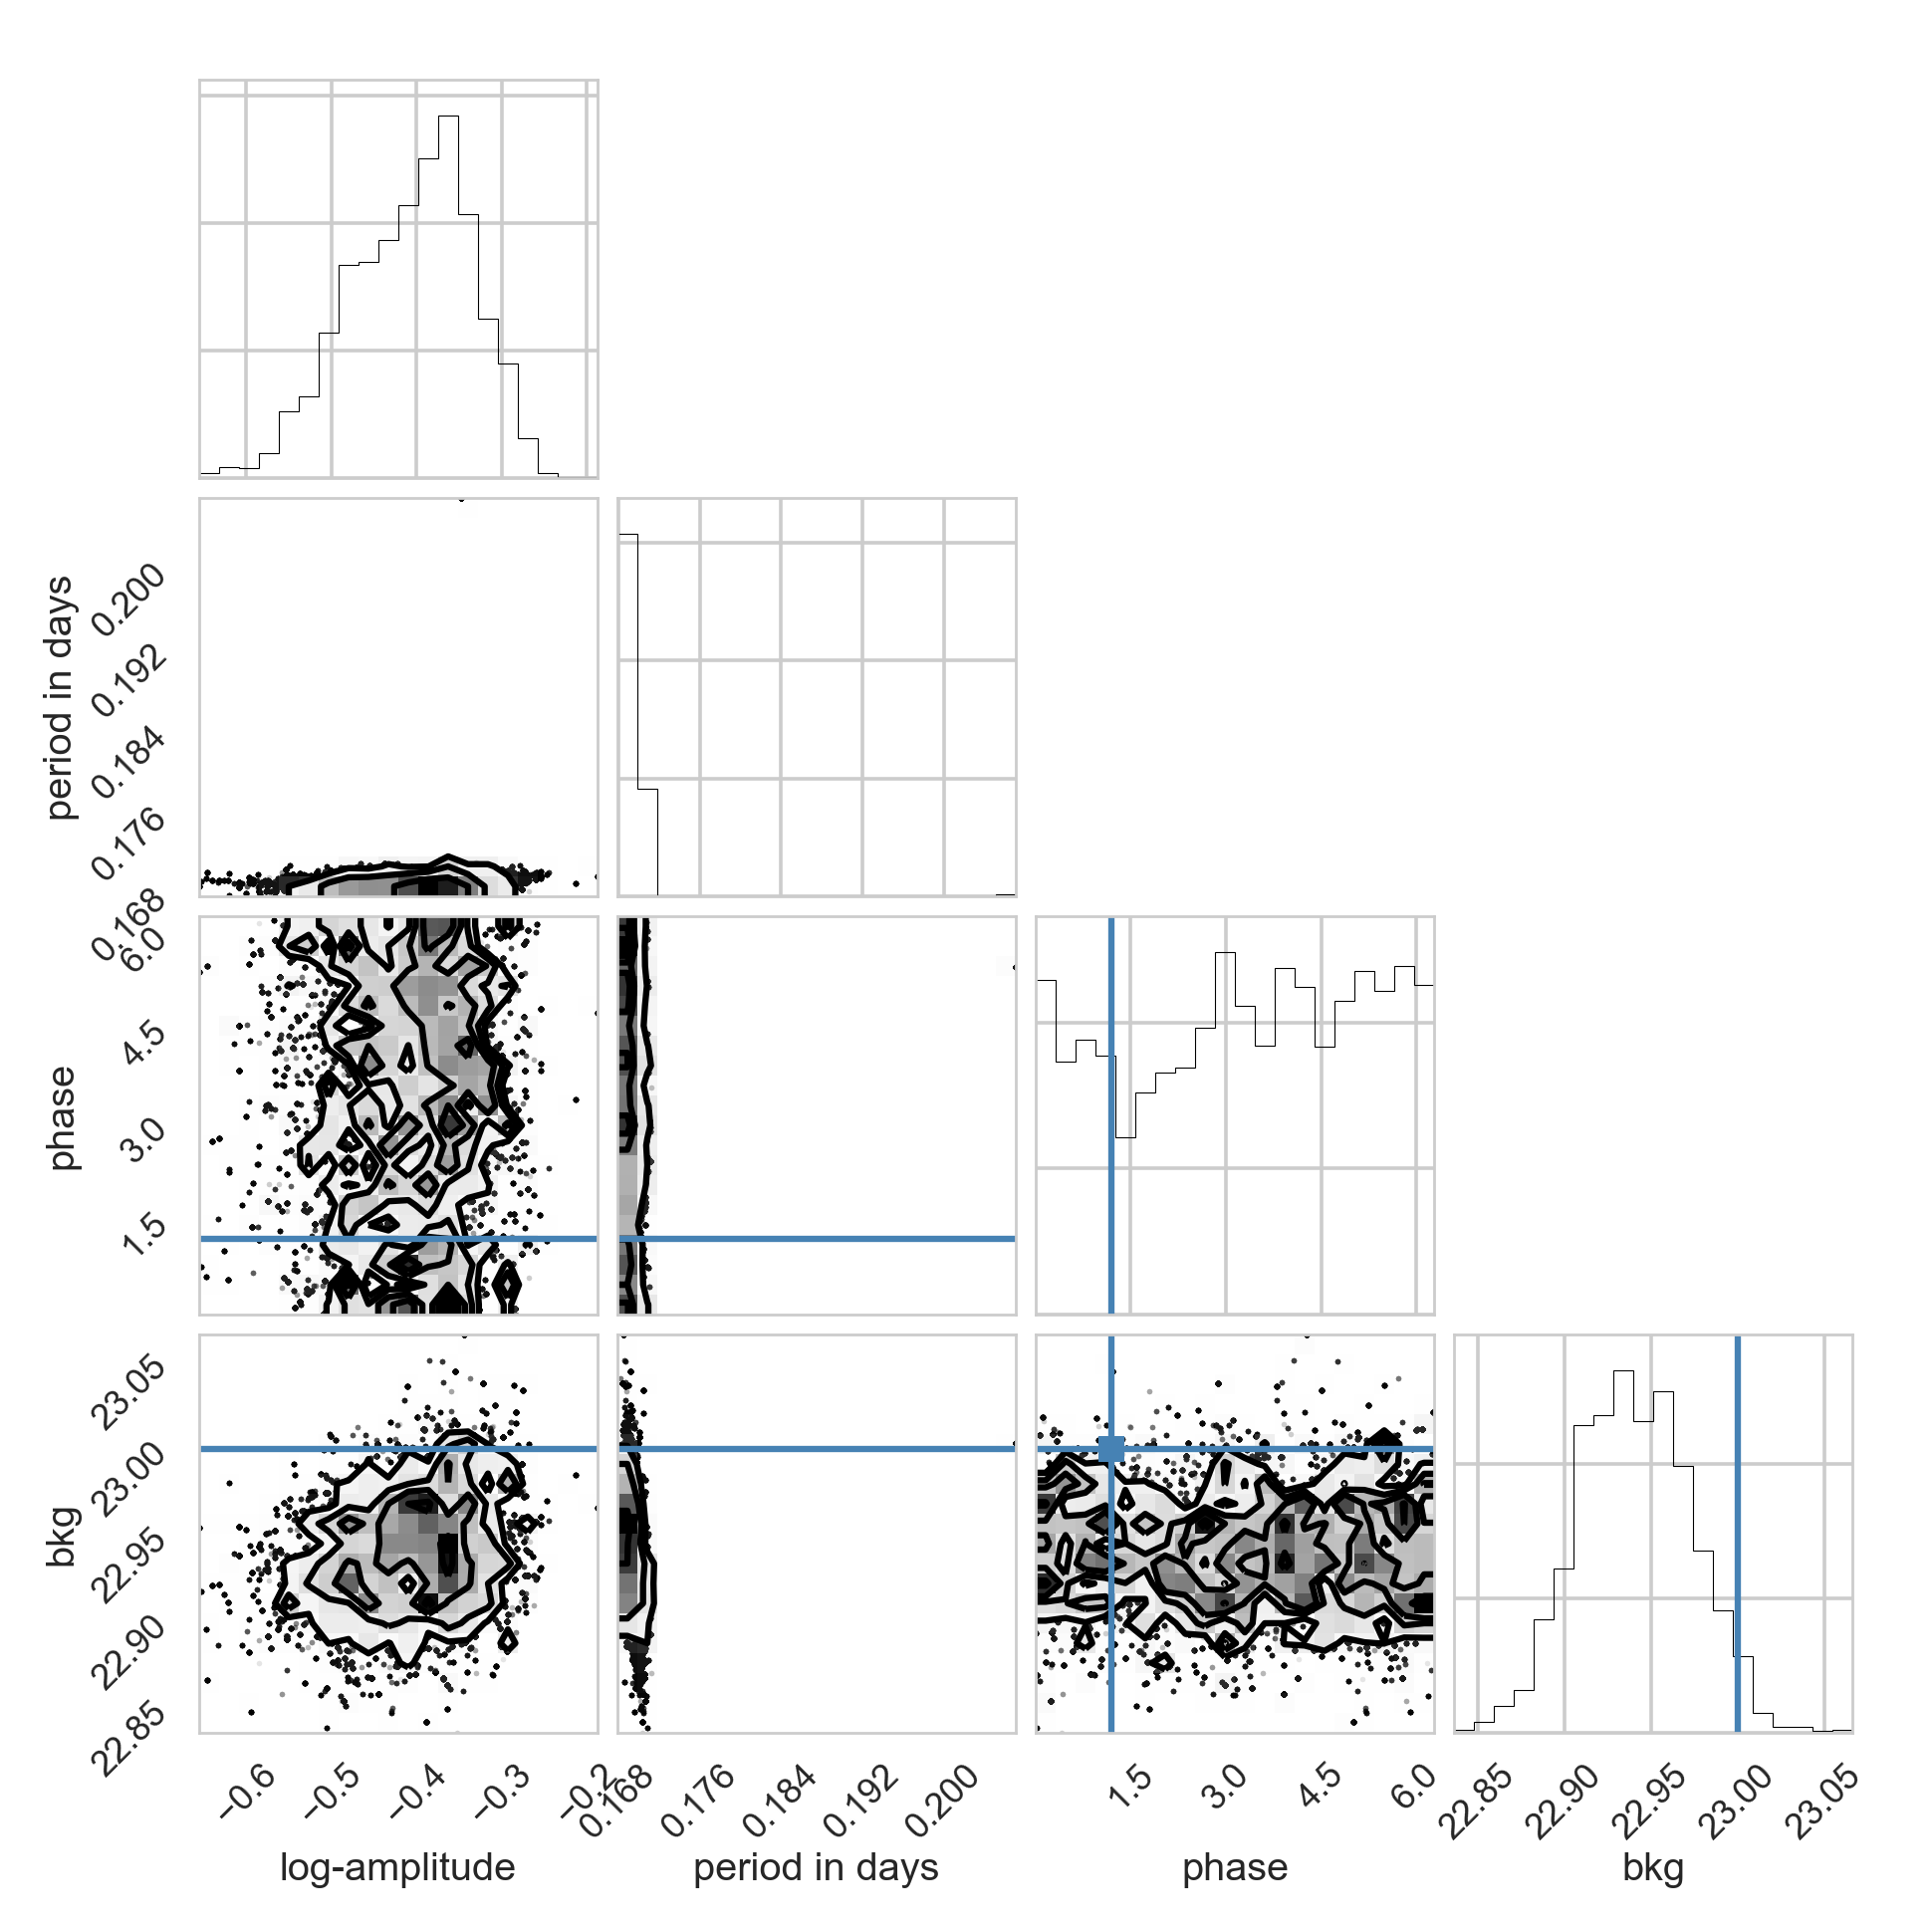

<IPython.core.display.Javascript object>


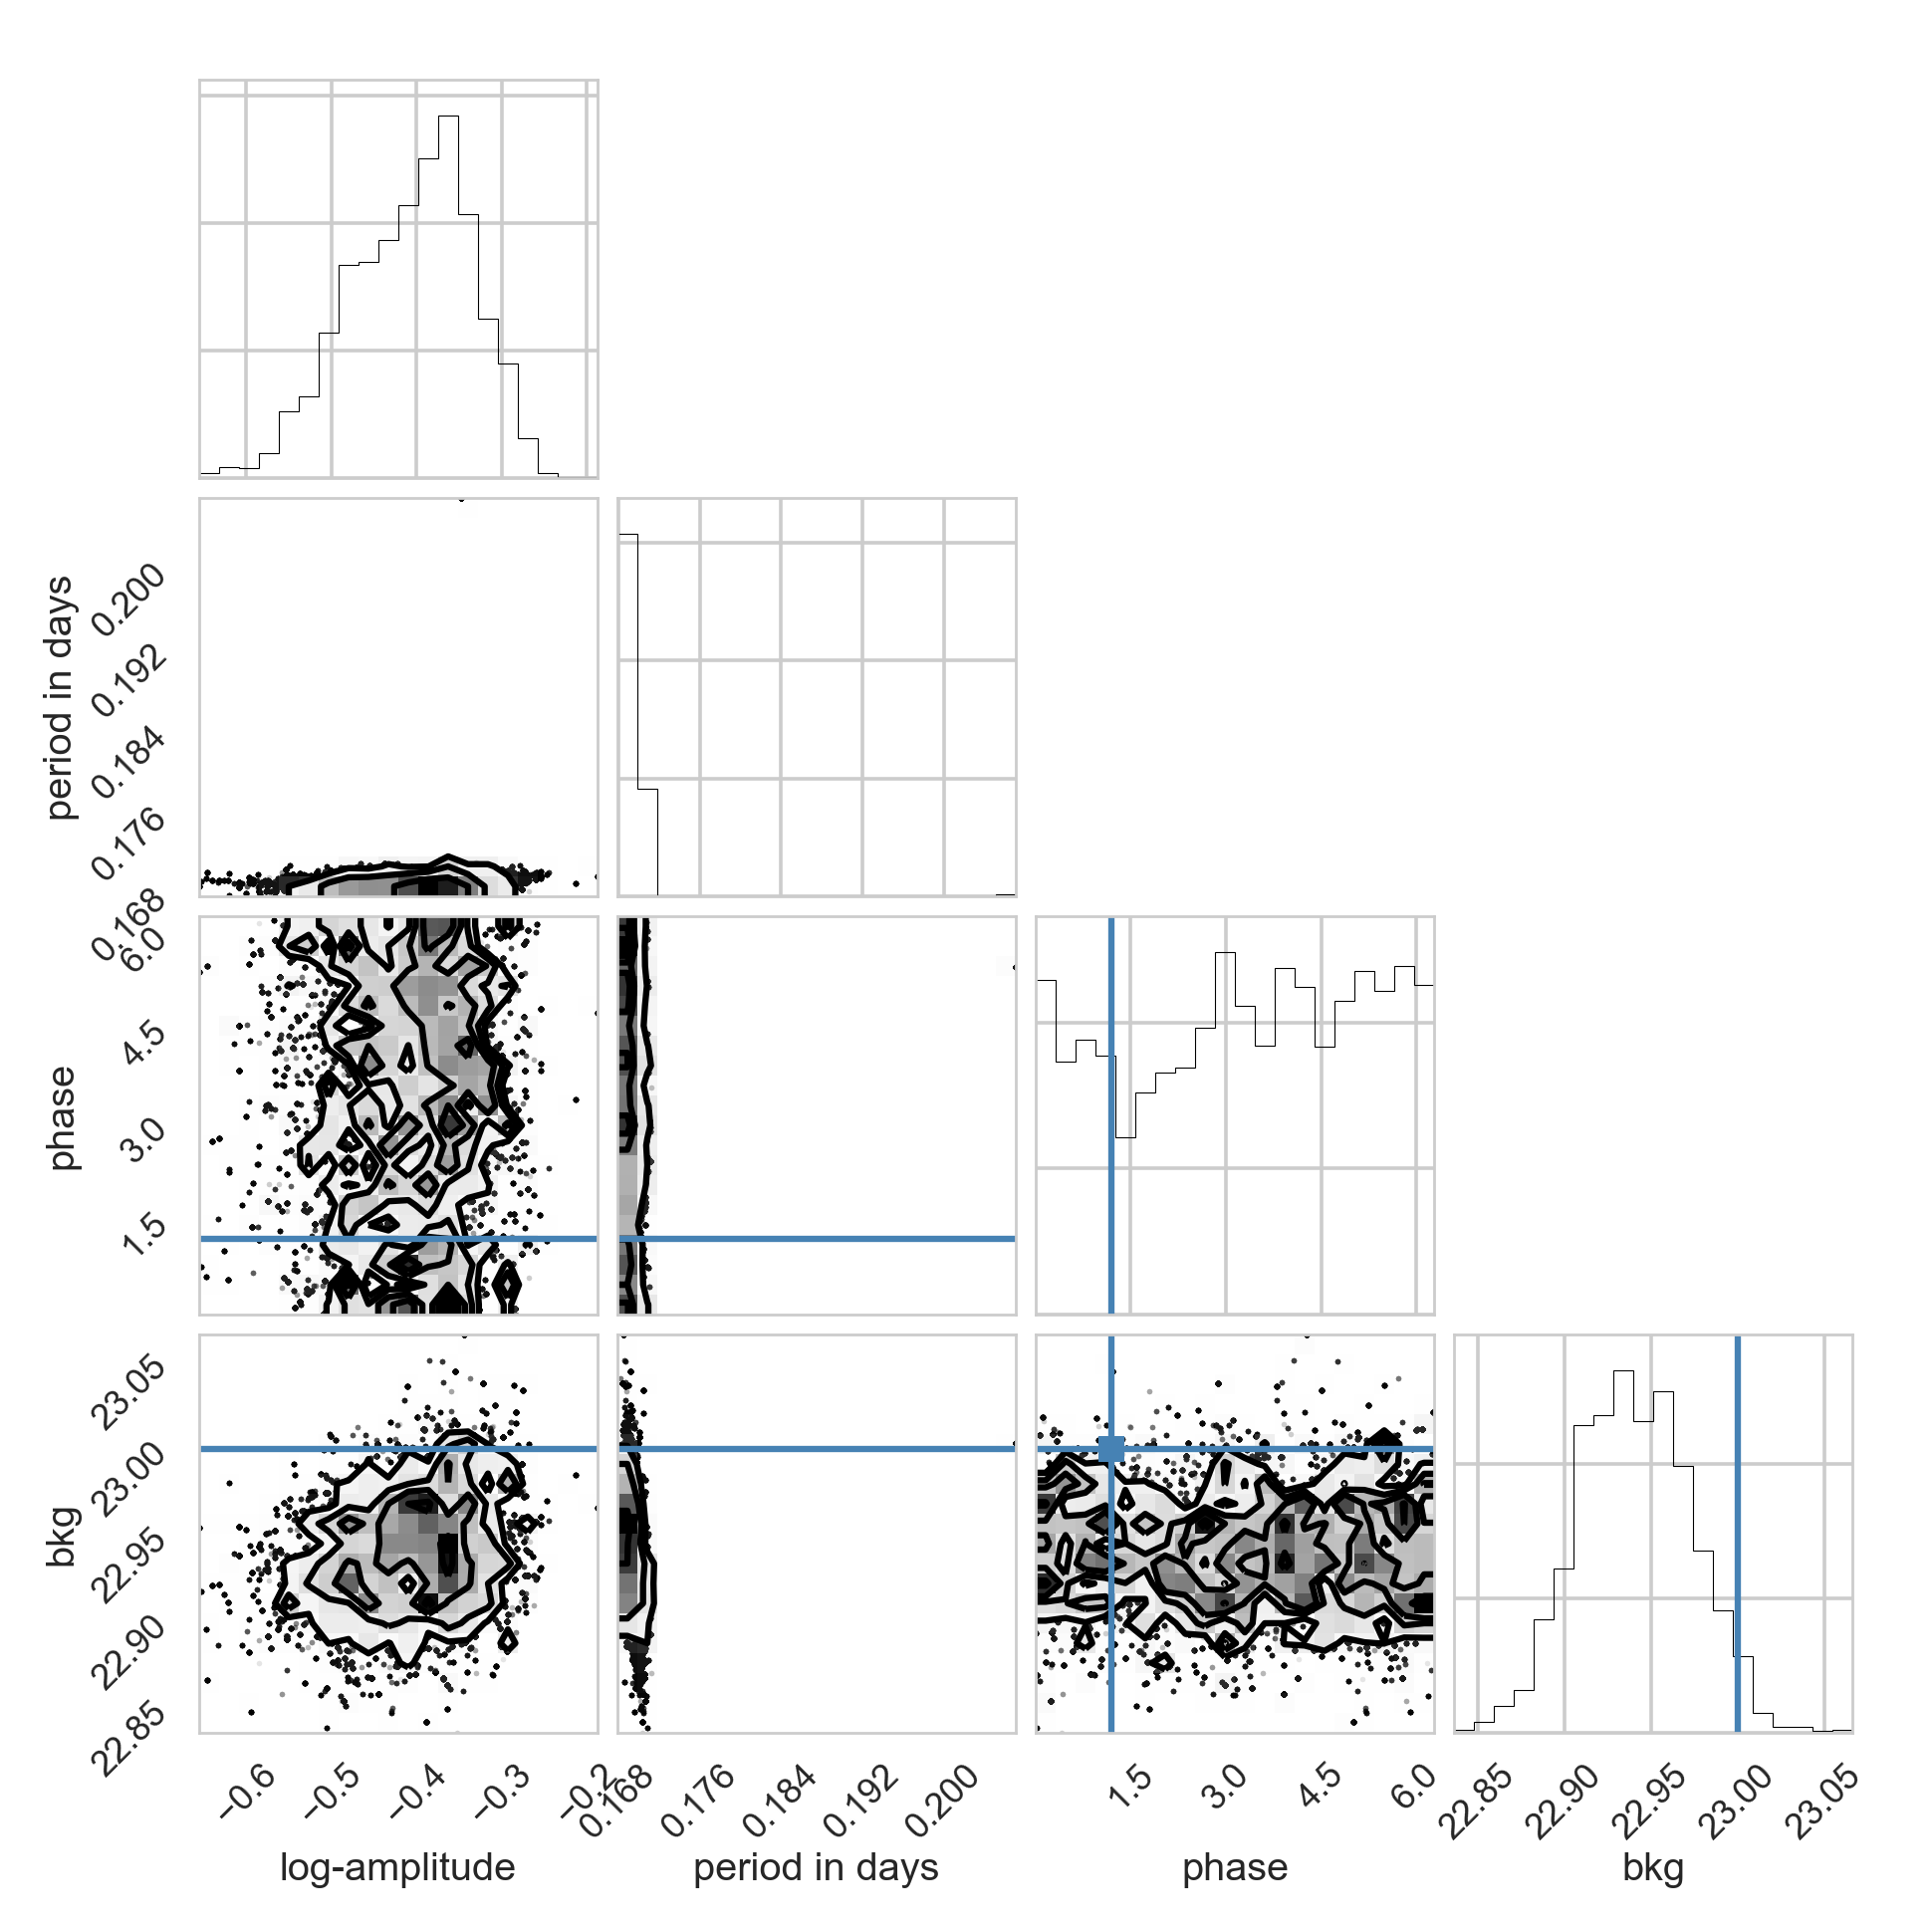

In [110]:
corner.corner(flatchain, labels=names, truths=true_pars)

Let's make a plot of some posterior samples:

<IPython.core.display.Javascript object>


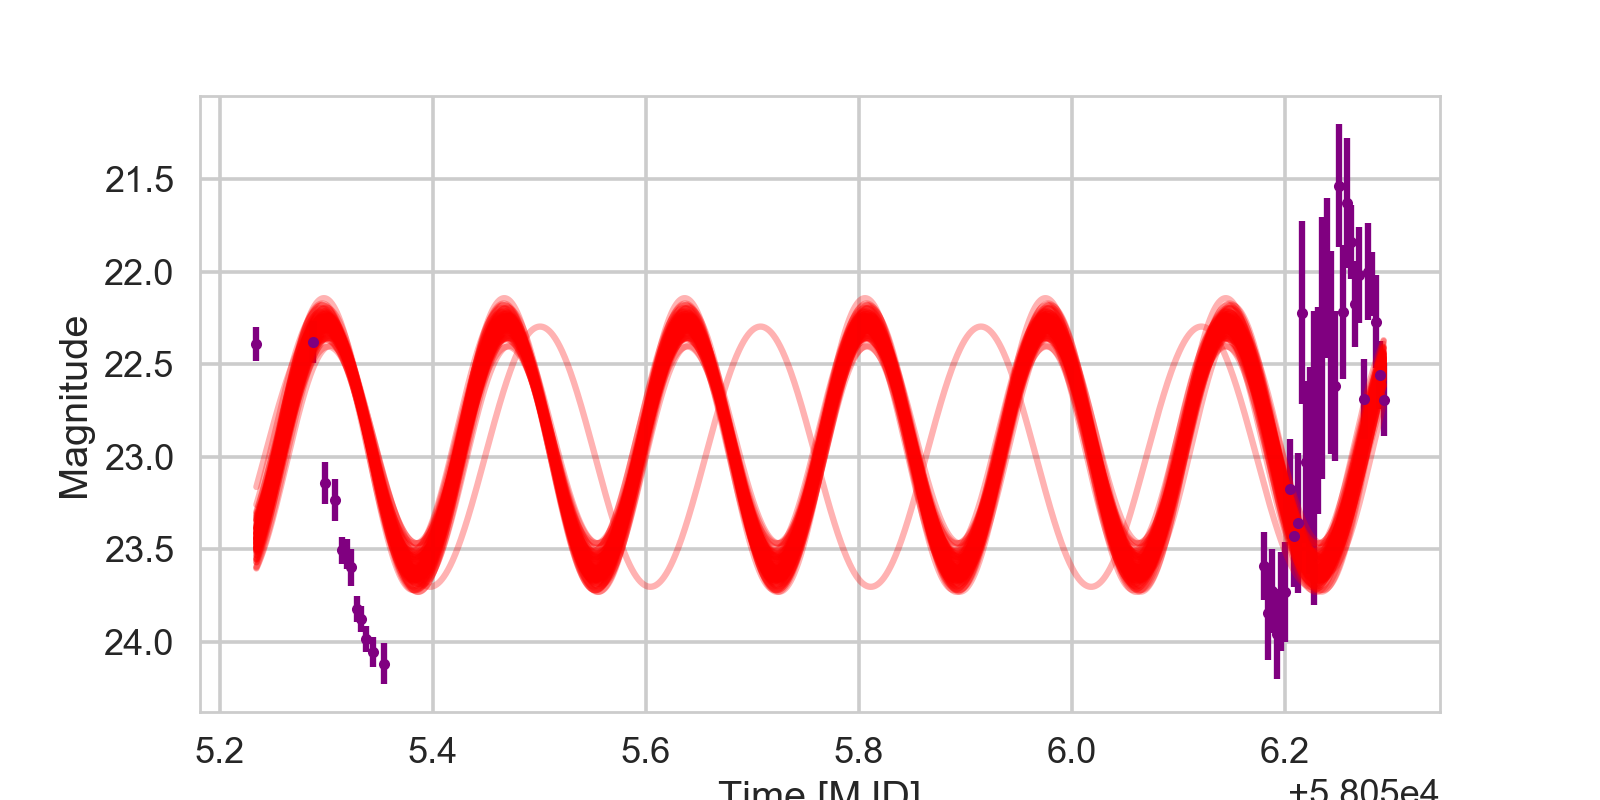

In [111]:
plt.figure(figsize=(8,4))

plt.errorbar(time, fake_mag, yerr=mag_err,
             color="purple", fmt="o", markersize=4)


for i in range(100):
    # Choose a random walker and step.
    w = np.random.randint(sampler.chain.shape[0])
    n = np.random.randint(sampler.chain.shape[1]-100)+100
    p = sampler.chain[w, n]
    m = sinusoid(model_time, *p)
    # Plot a single sample.
    plt.plot(model_time, m, alpha=0.3, color="red")

#plt.xlim(58055.2, 58057)
plt.xlabel("Time [MJD]")
plt.ylabel("Magnitude");
plt.gca().invert_yaxis()

Ok, that looks like it's doing the right thing. Let's do this on the real data:

In [202]:
start_pars = [0.0, 4/24., 1.8*np.pi, 23.3]

res = op.minimize(lpost, start_pars, args=(True), method="powell")

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [203]:
res.x

array([ -0.40641198,   0.16894768,   5.58910174,  22.95729016])

What does the model look like compared to the data?

In [204]:
model_time = np.linspace(time[0], time[-1], 2000)

In [205]:
m = sinusoid(model_time, *res.x)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


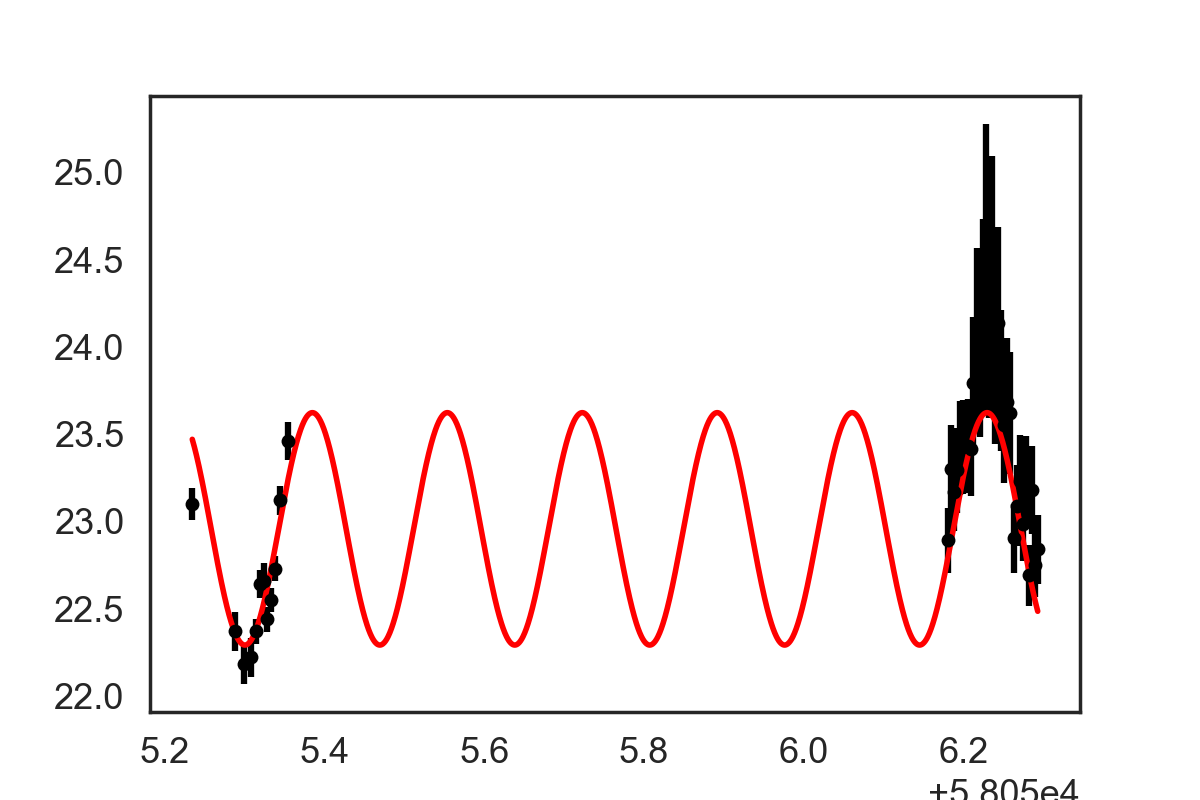

In [206]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.errorbar(time, mag, yerr=mag_err, fmt="o", markersize=5, color="black", label="data")
ax.plot(model_time, m, color="red", lw=2, label="best-fit model")

The pure sinusoidal fit looks ok, but not great. Let's take a look at some MCMC inference, which should hopefully be quick:

In [207]:
# Set up the sampler.
nwalkers, ndim = 200, 4
sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost, threads=4)

# Initialize the walkers.
p0 = res.x + 0.001 * np.random.randn(nwalkers, ndim)

for p in p0:
    print(lpost(p))

-828.073099712
-429.798767116
-80.5159898078
-21.1518225558
-491.485034845
-34.2142968722
-805.509466588
-534.203385628
-67.3963881772
-464.831053371
-835.849934759
-803.502139894
-528.288315294
-186.298055977
-305.573222874
-654.977189097
-287.086312012
-295.875760294
-36.2336303292
-814.483511706
-28.3847502927
-48.3895750626
-34.0425350964
-55.2492118095
-22.6189853801
-135.675206525
-820.916796263
-808.677664652
-54.6687897231
-121.129290941
-290.938300227
-360.708985709
-610.88542773
-243.184203369
-330.500429451
-425.111906518
-771.80049065
-51.5313289202
-257.129686978
-275.077396064
-271.920502872
-173.85170937
-249.154533167
-706.411543271
-803.87970062
-837.715598492
-206.84218089
-46.4482380072
-214.622091756
-302.681064309
-324.816867765
-407.461583032
-798.517407592
-330.487119463
-708.729443293
-462.974465894
-680.476284706
-89.1287097704
-672.562741662
-28.35562167
-280.340617675
-275.614046359
-261.43360887
-333.626142598
-39.3043094003
-367.341894918
-573.577137582
-14

In [208]:
print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 10000)

Running burn-in


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


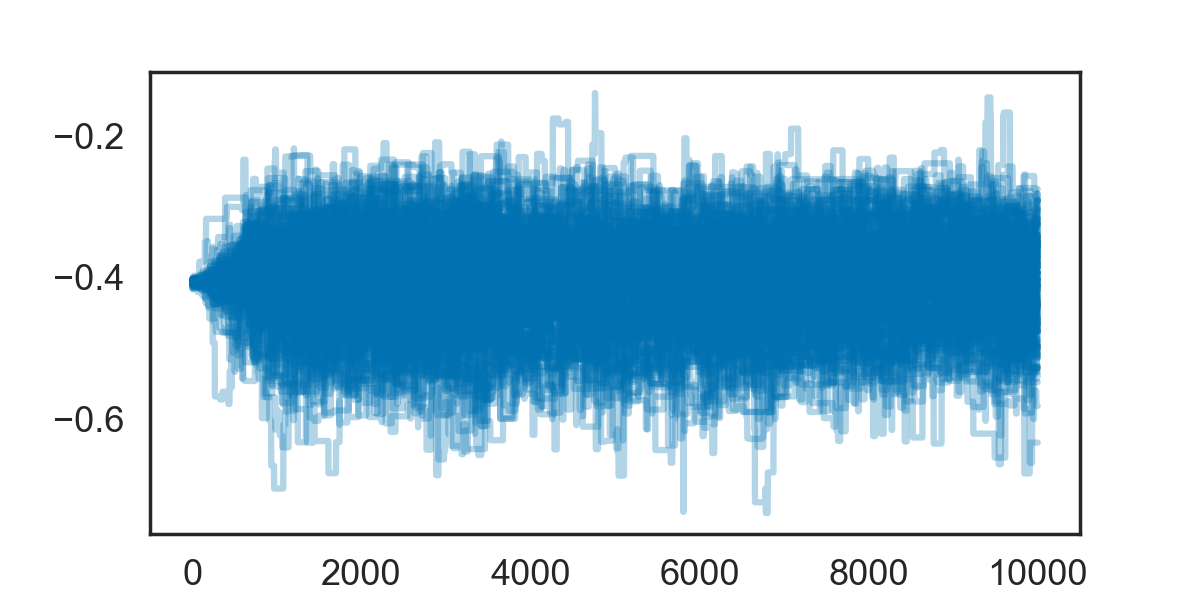

<IPython.core.display.Javascript object>


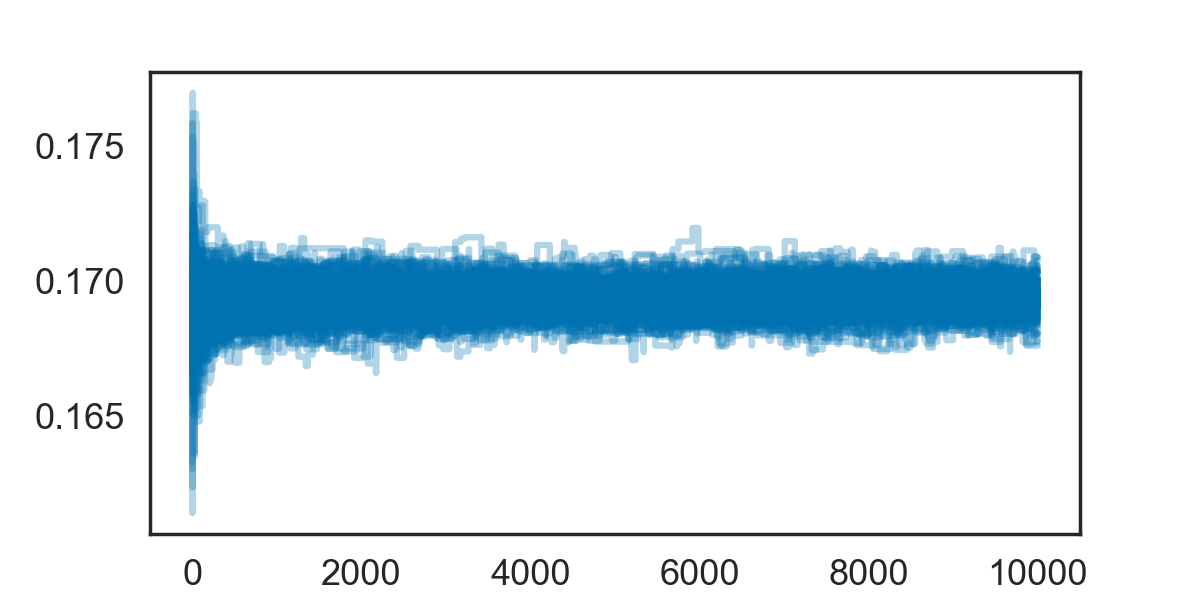

<IPython.core.display.Javascript object>


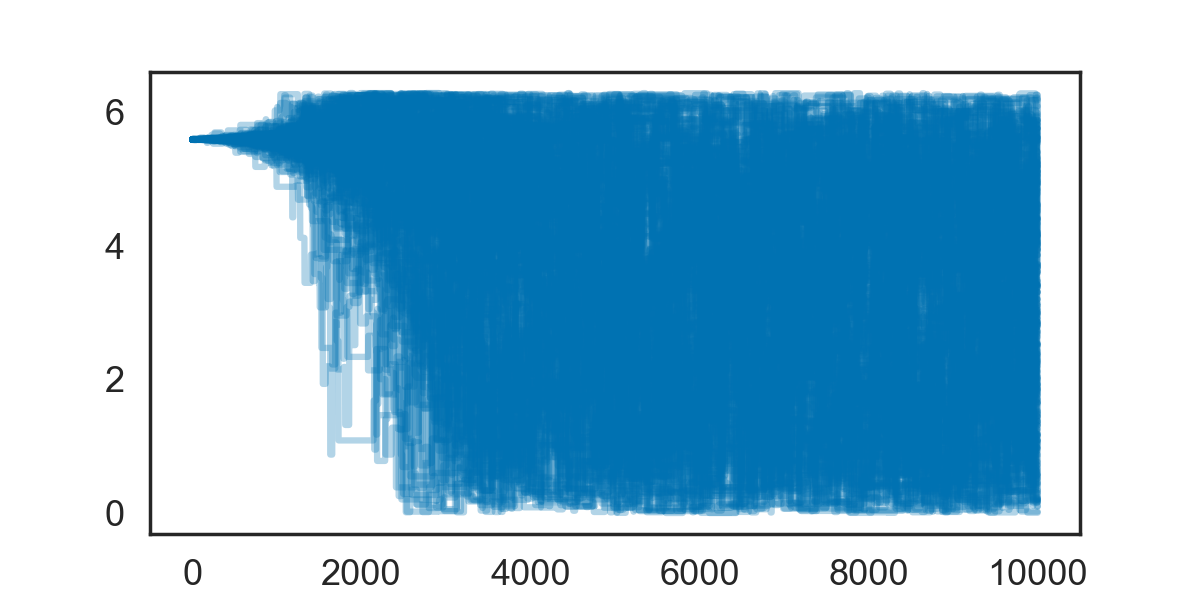

<IPython.core.display.Javascript object>


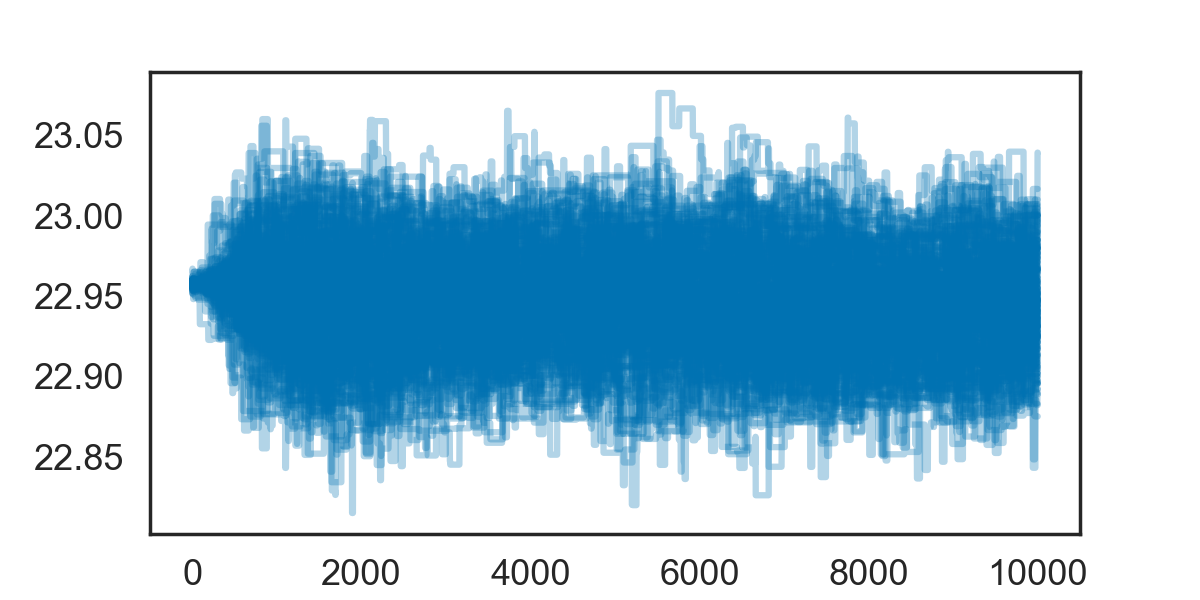

In [209]:
for i in range(ndim):
    fig, ax = plt.subplots(1, 1, figsize=(6,3))
    ax.plot(sampler.chain[:,:,i].T, color=sns.color_palette()[0], alpha=0.3)

Hmm, that looks ok, except for the phase, but I'm not super worried about the phase at the moment. Let's make a corner plot:

In [211]:
flatchain = np.concatenate(sampler.chain[:,-1000:, :], axis=0)

In [212]:
names = ["amplitude", "period in days", "phase", "bkg"]

In [213]:
flatchain[:,0] = np.exp(flatchain[:,0])

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


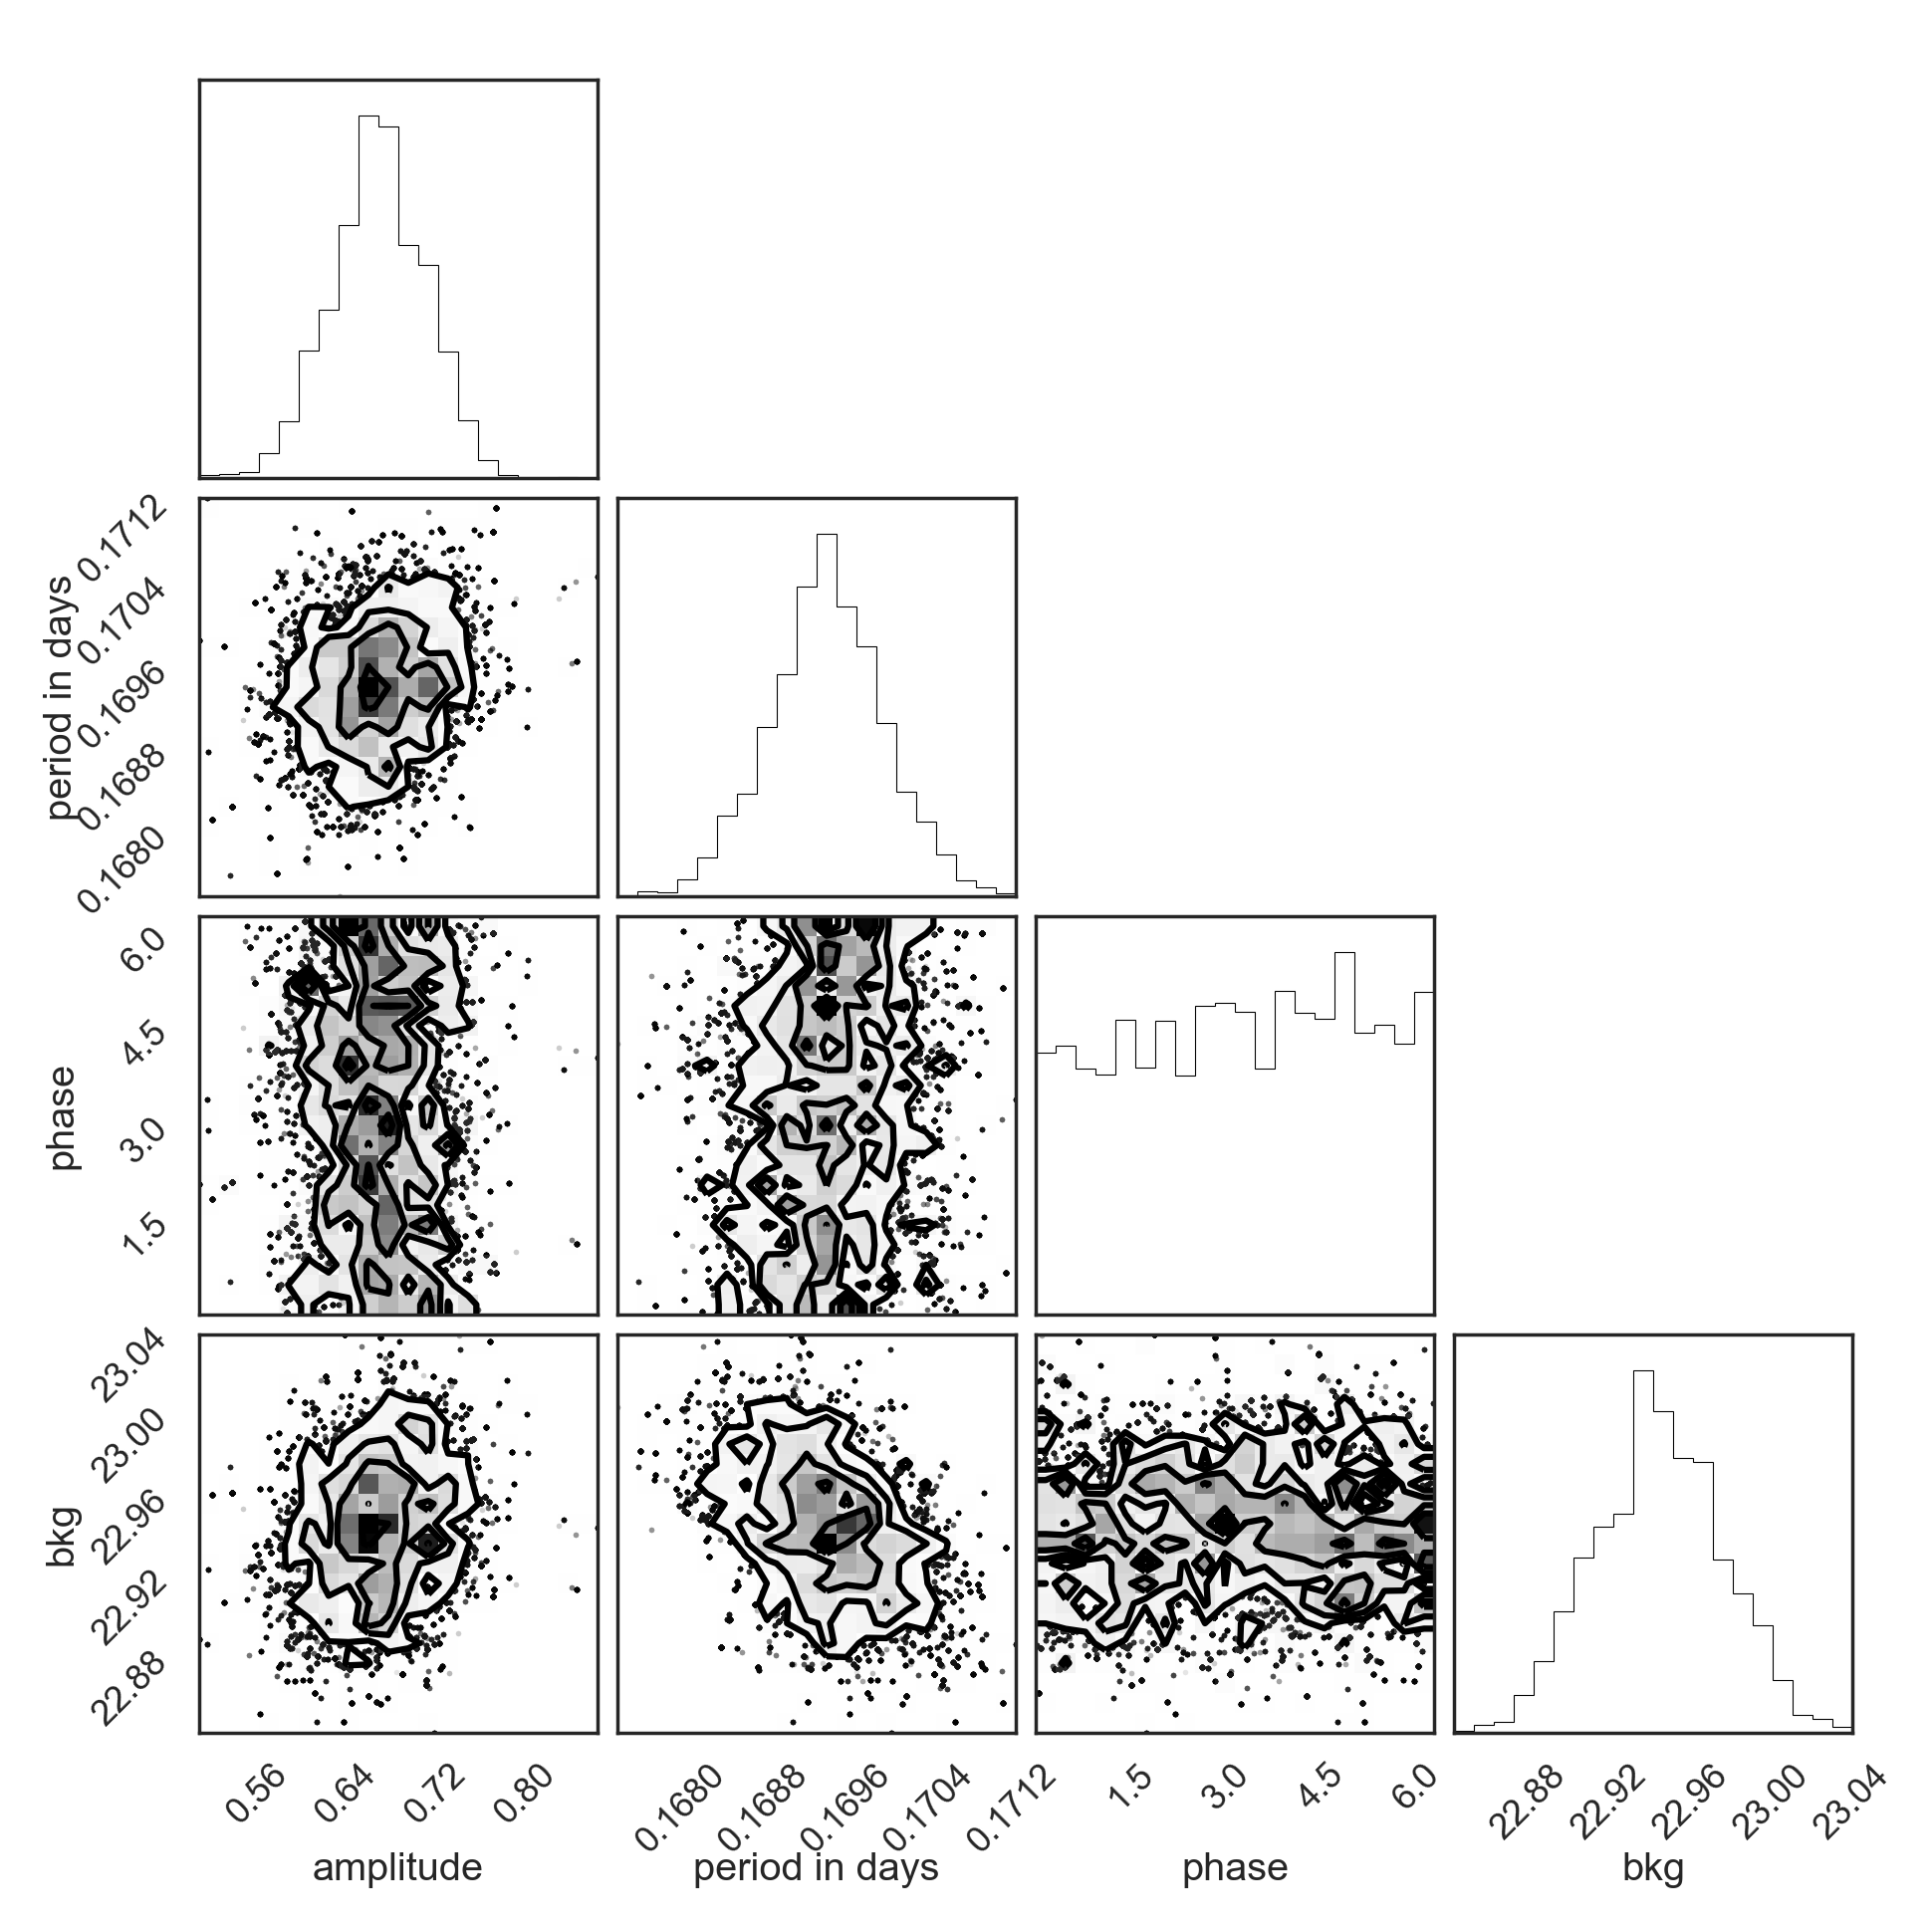

In [214]:
corner.corner(flatchain, labels=names);

Let's look at the posterior means and percentiles:

First, the amplitude:

In [215]:
np.mean(flatchain[:,0], axis=0)

0.66857678862922398

In [216]:
np.percentile(flatchain[:,0], [50-68.27/2.0, 50, 50+68.27/2.], axis=0)

array([ 0.6259618 ,  0.66843342,  0.71225337])

In [217]:
0.63828670337044935 - 0.59034186

0.04794484337044935

In [218]:
0.68694518 - 0.63828670337044935

0.048658476629550695

Then the period:

In [230]:
flatchain[:, 1] = np.log(flatchain[:,1])

In [232]:
np.mean(flatchain[:,1], axis=0)*24.

4.0659269767275319

In [233]:
np.percentile(flatchain[:,1], [50-68.27/2.0, 50, 50+68.27/2.], axis=0)*24.

array([ 4.05313703,  4.06599216,  4.07848433])

In [234]:
4.0659269767275319 - 4.05313703

0.012789946727531643

In [235]:
4.07848433 - 4.0659269767275319

0.012557353272468319

And finally for the background parameter

In [223]:
np.mean(flatchain[:,-1], axis=0)

22.944213623929919

In [224]:
np.percentile(flatchain[:,-1], [50-68.27/2.0, 50, 50+68.27/2.], axis=0)

array([ 22.91086011,  22.9437083 ,  22.97649209])

In [225]:
50+68.27/2.0

84.13499999999999

Okay, so those are my numbers for the percentiles, and they're all pretty well-constrained. Let's plot some example light curves and the phase-folded light curve:

In [136]:
phase = time/0.16946752939309517 % 1
phase *= (2.*np.pi)

In [237]:
max_ind = time.searchsorted(58055.5)

In [140]:
sns.set_style("white")

In [143]:
labels = ["0", r"$\frac{1}{2}\pi$", r"$\pi$", r"$\frac{3}{2}\pi$", r"$2\pi$"]
ticks = [0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]

In [144]:
0.16946752939309517*24

4.067220705434284

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


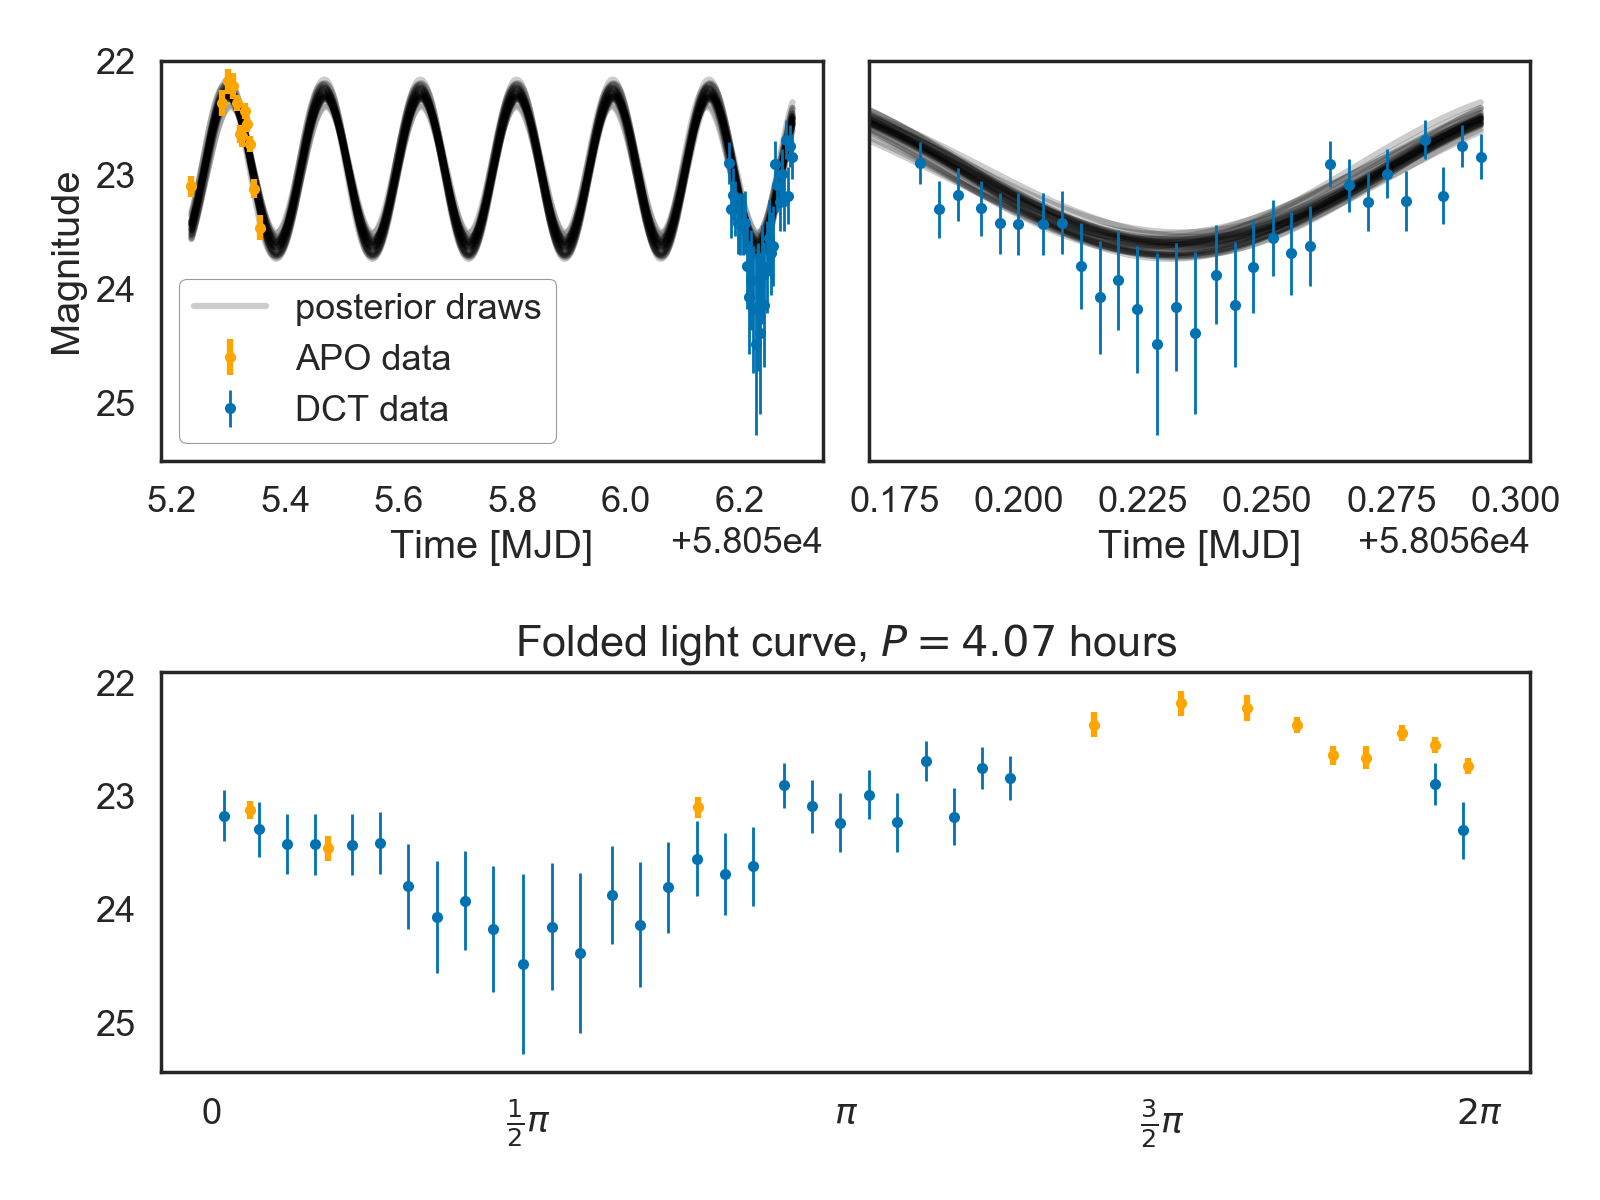

In [239]:
#fig, (ax1, ax2) = plt.subplots(,2, figsize=(8,4))

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)


ax1.errorbar(time[:max_ind], mag[:max_ind], yerr=mag_err[:max_ind],
             color="orange", fmt="o", markersize=4, label="APO data")

ax1.errorbar(time[max_ind:], mag[max_ind:], yerr=mag_err[max_ind:],
             color=sns.color_palette("colorblind")[0], fmt="o", markersize=4, 
             lw=1, label="DCT data")


ax2.errorbar(time, mag, yerr=mag_err,
             color=sns.color_palette("colorblind")[0], fmt="o", lw=1, markersize=4, 
             label="DCT data")

flatchain = np.concatenate(sampler.chain[:,-1000:, :], axis=0)
for i in range(30):
    # Choose a random walker and step.
    w = np.random.randint(flatchain.shape[0])
    p = flatchain[w]
    ph = (p[2]/(2.0*np.pi) - int(p[2]/(2.0*np.pi))) * 2 * np.pi
    m = sinusoid(model_time, p[0], p[1], ph, p[3])
#    # Plot a single sample.
    if i == 0:
        ax1.plot(model_time, m, alpha=0.2, color="black", 
                 label="posterior draws", zorder=0)
        ax2.plot(model_time, m, alpha=0.2, color="black", 
                 label="posterior draws", zorder=0)
    else:
        ax1.plot(model_time, m, alpha=0.2, color="black", zorder=0)
        ax2.plot(model_time, m, alpha=0.2, color="black", zorder=0)


#ax1.set_xlim(58055.2, 58056.32)
ax1.set_xlabel("Time [MJD]")
ax1.set_ylabel("Magnitude");
leg = ax1.legend(frameon=True)
leg.get_frame().set_edgecolor('grey')

ax1.set_ylim(22, 25.5)
ax1.set_ylim(ax1.get_ylim()[::-1])

ax2.set_xlim(58056.17, max(time)+0.01)
ax2.set_xlabel("Time [MJD]")
ax2.set_yticklabels([])
ax2.set_ylim(22, 25.5)
ax2.set_ylim(ax2.get_ylim()[::-1])

ax3.errorbar(phase[:max_ind], mag[:max_ind], yerr=mag_err[:max_ind],
             color="orange", fmt="o", markersize=4, label="APO data")

ax3.errorbar(phase[max_ind:], mag[max_ind:], yerr=mag_err[max_ind:],
             color=sns.color_palette("colorblind")[0], fmt="o", markersize=4, 
             lw=1, label="DCT data")


ax3.set_xticks(ticks)
ax3.set_xticklabels(labels)
ax3.set_title(r"Folded light curve, $P = 4.07$ hours")
ax3.set_ylim(ax3.get_ylim()[::-1])
plt.tight_layout()

plt.savefig("comet_sine_lcs.eps", format="eps")

Okay, so that's my inference for the sinusoidal model. It's not clear that a sinusoidal model is a good idea, because the model could be double-peaked or have other deformations.

### Gaussian Process Model

We should fit a Gaussian Process model instead, so let's try doing that.

In particular, the sine-squared exponential is probably the right model, because it defines a periodic but non-sinusoidal model.

<IPython.core.display.Javascript object>


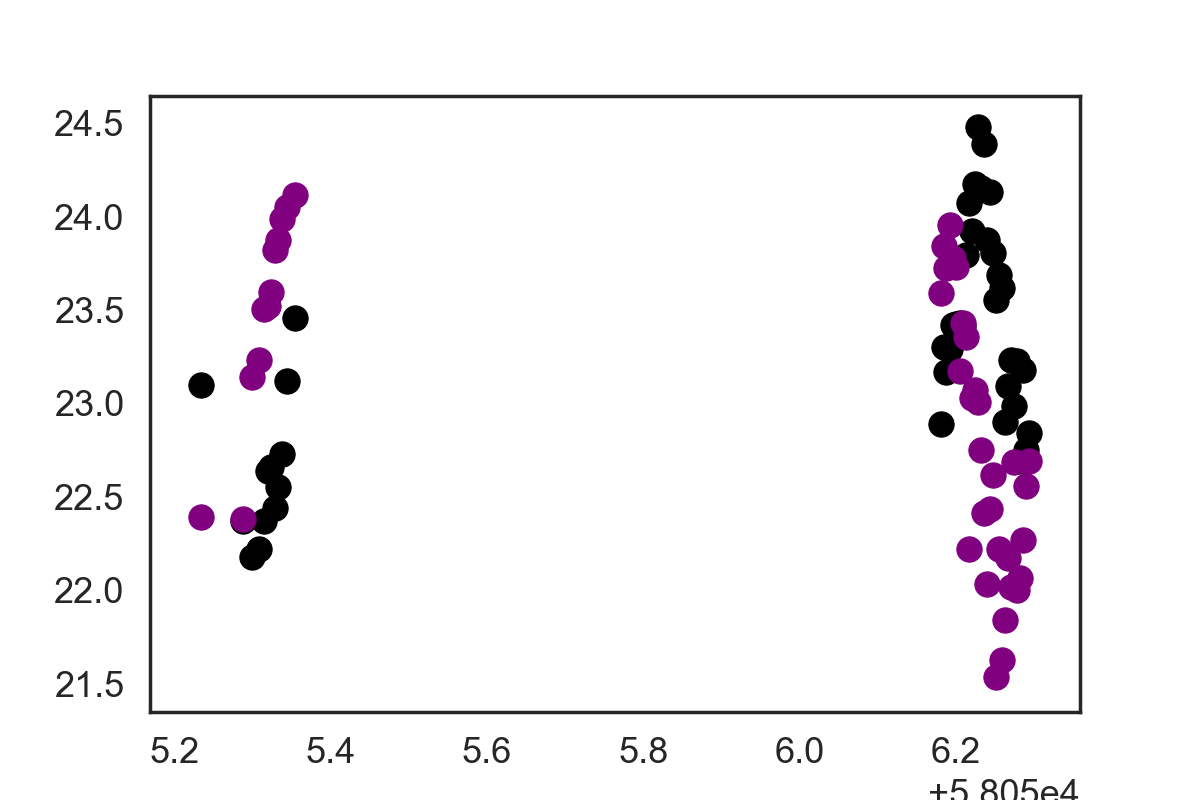

In [146]:
plt.figure(figsize=(6,4))
plt.scatter(time, mag, color="black")
plt.scatter(time, fake_mag, color="purple")

In [147]:
from george import kernels
import george

Let's first test this on the simulated data!

In [148]:
kernel = 10 * kernels.ExpSine2Kernel(gamma=1, log_period=np.log(8/24.0),)

<IPython.core.display.Javascript object>


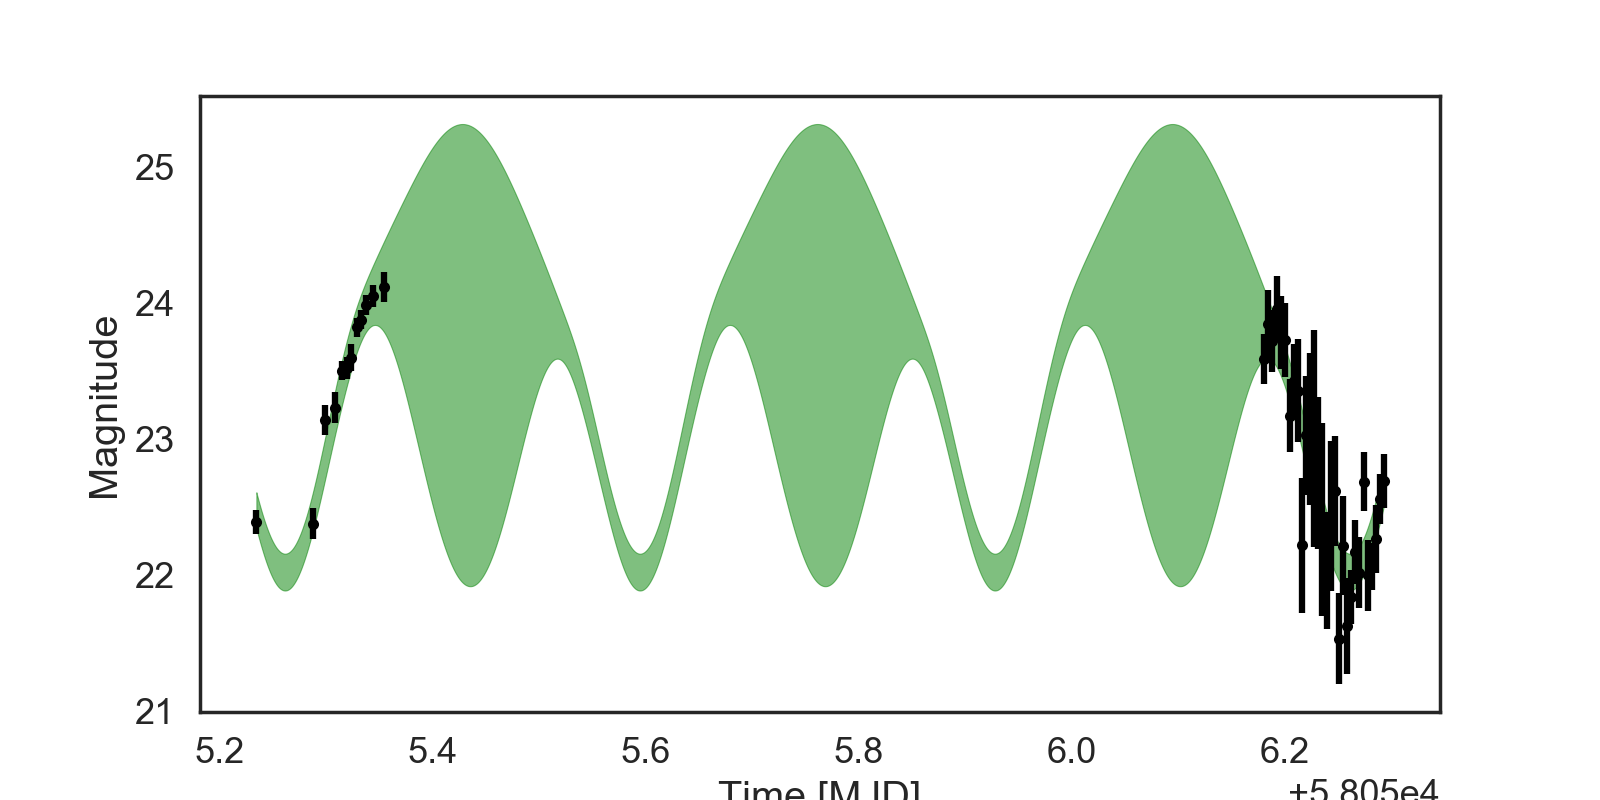

In [149]:
gp = george.GP(kernel, mean=np.mean(fake_mag), fit_mean=True,
               white_noise=np.mean(np.log(mag_err)), fit_white_noise=False)
gp.compute(time)

x = np.linspace(np.min(time), np.max(time), 5000)
mu, var = gp.predict(fake_mag, x, return_var=True)
std = np.sqrt(var)

plt.figure(figsize=(8,4))
plt.errorbar(time, fake_mag, yerr=mag_err,
             color="black", fmt="o", markersize=4)
plt.fill_between(x, mu+std, mu-std, color="g", alpha=0.5)

#plt.xlim(58054, np.max(time)+0.3)
plt.xlabel("Time [MJD]")
plt.ylabel("Magnitude");

-24.5804089218
[ 23.37731579  -0.35351321   6.13472345  -0.68884836]
-22.0151875071


<IPython.core.display.Javascript object>


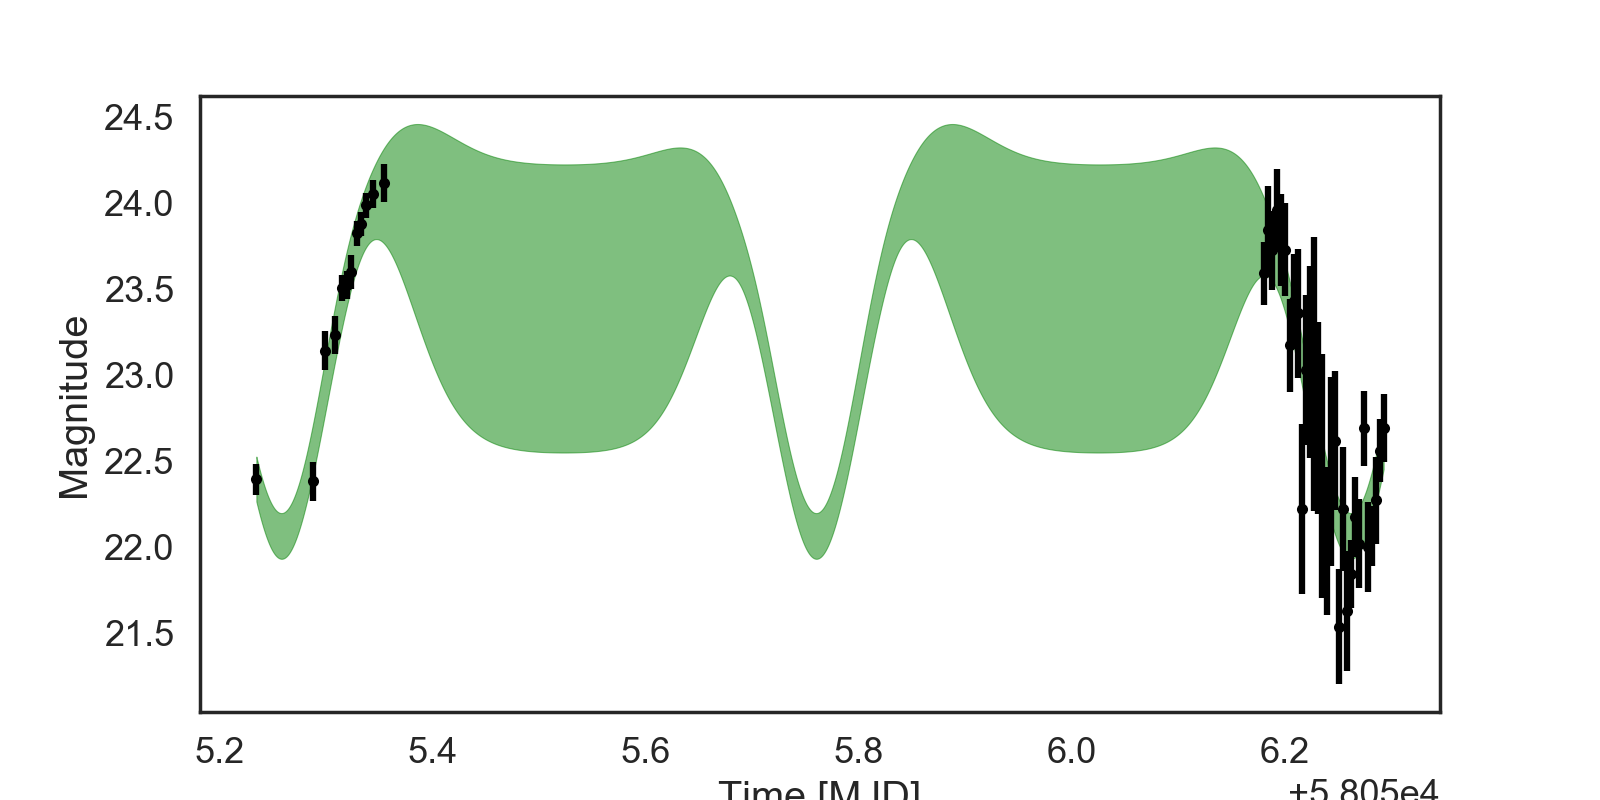

In [150]:
# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(fake_mag, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(fake_mag, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(time)

# Print the initial ln-likelihood.
print(gp.log_likelihood(fake_mag))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(results.x)
print(gp.log_likelihood(fake_mag))

x = np.linspace(np.min(time), np.max(time), 5000)
mu, var = gp.predict(fake_mag, x, return_var=True)
std = np.sqrt(var)

plt.figure(figsize=(8,4))
plt.errorbar(time, fake_mag, yerr=data["mag_err"],
             color="black", fmt="o", markersize=4)
plt.fill_between(x, mu+std, mu-std, color="g", alpha=0.5)

plt.xlabel("Time [MJD]")
plt.ylabel("Magnitude");

In [154]:
def lnprob(p): 
    mean = p[0]
    logamplitude = p[1]
    loggamma = p[2]
    logperiod = p[3]
    
    if mean < -100 or mean > 100:
    #    print("boo! 0")
        return -np.inf
    
    # prior on log-amplitude: flat and uninformative
    if logamplitude < -100 or logamplitude > 100:
        #print("boo! 1")
        return -np.inf
    
    # prior on log-gamma of the periodic signal: constant and uninformative
    elif loggamma < -20 or loggamma > 20:
        #print("boo! 2")
        return -np.inf
        
    # prior on the period: somewhere between 30 minutes and 2 days
    elif logperiod < np.log(1/24) or logperiod > np.log(23/24.0):
        #print("boo! 4")
        return -np.inf
    
    else:
        pnew = np.array([mean, logamplitude, np.exp(loggamma), logperiod])
        #print("yay!")
        # Update the kernel and compute the lnlikelihood.
        gp.set_parameter_vector(pnew)
        return gp.lnlikelihood(fake_mag, quiet=True)


In [155]:
gp.compute(time)

# Set up the sampler.
nwalkers, ndim = 100, len(results.x)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=4)

# Initialize the walkers.

p0 = results.x + 0.01 * np.random.randn(nwalkers, ndim)

for p in p0:
    print(lnprob(p))

-38.3349782005
-38.0638768651
-39.0315561934
-37.9555776274
-37.8574989383
-37.7542815443
-37.7380016641
-38.4715192507
-38.7983868497
-38.379047325
-37.9270588087
-38.5083440925
-38.2121434995
-37.6844172754
-38.7137103429
-37.8012503959
-38.4111649822
-38.219488073
-38.258029995
-37.6279681258
-37.749763679
-37.8508849603
-37.7045711788
-38.2086105008
-37.80408253
-38.4374718049
-38.6467561766
-37.6447992424
-38.6995595433
-38.5420176343
-37.5848603741
-38.635855424
-37.6424244686
-38.6705868002
-38.4087550072
-38.1435783881
-37.6515136968
-38.2142432204
-37.6999910864
-38.1555356667
-38.3575817234
-37.7064626102
-37.6798873215
-37.6134330566
-39.9529218684
-37.8299002639
-37.9349270093
-38.4711258314
-37.8049182819
-38.317520658
-37.8576115045
-38.1508230262
-38.3956052222
-37.9170623116
-37.868261225
-37.8234242523
-38.1620564405
-38.0027929781
-38.1992867655
-37.6993830859
-38.3006987277
-42.5198759305
-37.8054431313
-37.8766130516
-38.3588513942
-38.2319686589
-38.0211496471
-38.

In [ ]:
print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 10000)

In [ ]:
sampler.acceptance_fraction

In [ ]:
for i in range(ndim):
    fig, ax = plt.subplots(1, 1, figsize=(6,3))
    ax.plot(sampler.chain[:,:,i].T, color=sns.color_palette()[0], alpha=0.3)

In [ ]:
flatchain = np.concatenate(sampler.chain[:,-1000:,:], axis=0)

In [ ]:
labels = ["log(Amplitude)", r"$\Gamma$", "log(Period)"]
corner.corner(flatchain[:,1:], labels=labels);

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(flatchain[:,-1], bins=200);

Now we can repeat the procedure on real data:

In [240]:
kernel = 10 * kernels.ExpSine2Kernel(gamma=10, log_period=np.log(8/24.0),)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


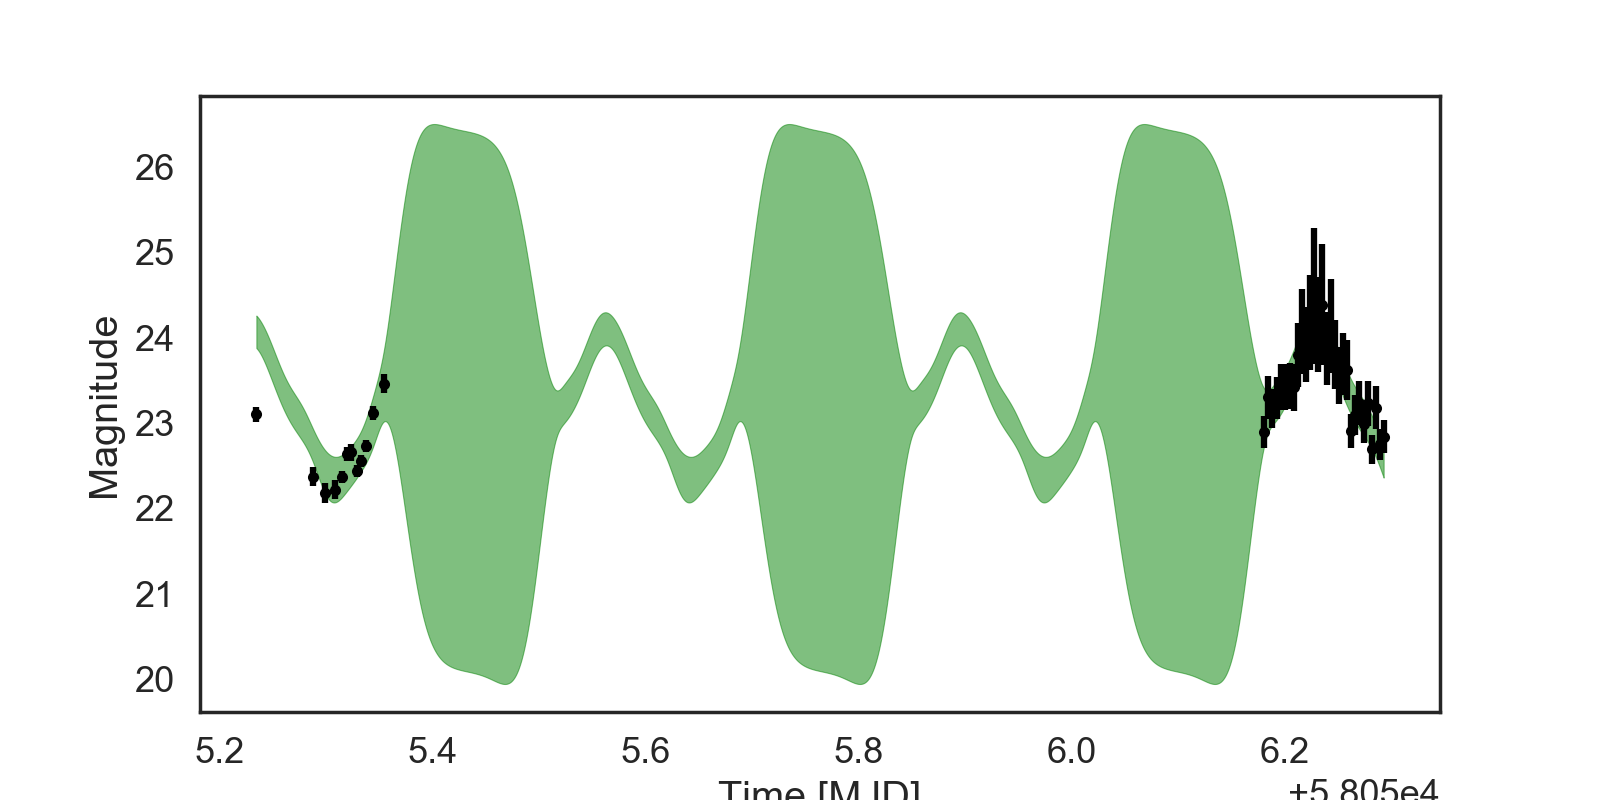

In [241]:
gp = george.GP(kernel, mean=np.mean(mag), fit_mean=True,
               white_noise=np.mean(np.log(mag_err)), fit_white_noise=False)
gp.compute(time)

x = np.linspace(np.min(time), np.max(time), 5000)
mu, var = gp.predict(mag, x, return_var=True)
std = np.sqrt(var)

plt.figure(figsize=(8,4))
plt.errorbar(time, mag, yerr=mag_err,
             color="black", fmt="o", markersize=4)
plt.fill_between(x, mu+std, mu-std, color="g", alpha=0.5)

#plt.xlim(58054, np.max(time)+0.3)
plt.xlabel("Time [MJD]")
plt.ylabel("Magnitude");

-33.5805000444
[ 23.11409118  -1.18774347  14.31906101  -0.65765601]
-19.5621455583


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


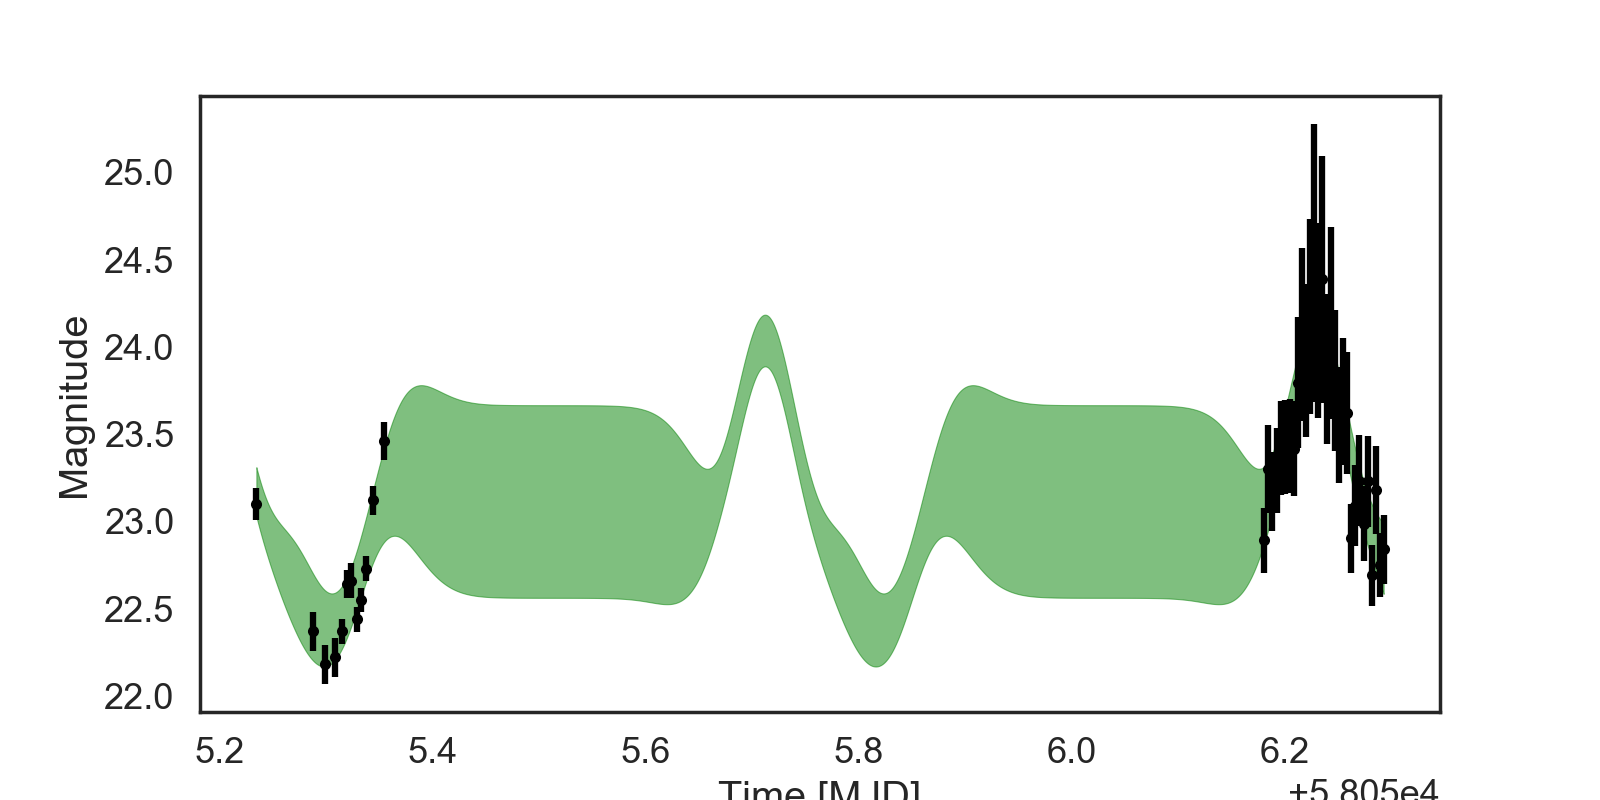

In [243]:
# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(mag, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(mag, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(time)

# Print the initial ln-likelihood.
print(gp.log_likelihood(mag))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(results.x)
print(gp.log_likelihood(mag))

x = np.linspace(np.min(time), np.max(time), 5000)
mu, var = gp.predict(mag, x, return_var=True)
std = np.sqrt(var)

plt.figure(figsize=(8,4))
plt.errorbar(time, mag, yerr=data["mag_err"],
             color="black", fmt="o", markersize=4)
plt.fill_between(x, mu+std, mu-std, color="g", alpha=0.5)

plt.xlabel("Time [MJD]")
plt.ylabel("Magnitude");

In [244]:
import scipy.stats

In [245]:
def lnprob(p):
    
    mean = p[0]
    logamplitude = p[1]
    loggamma = p[2]
    logperiod = p[3]
    
    if mean < -100 or mean > 100:
        #print("boo! 0")
        return -np.inf
    
    # prior on log-amplitude: flat and uninformative
    elif logamplitude < -100 or logamplitude > 100:
        #print("boo! 1")
        return -np.inf
    
    # prior on log-gamma of the periodic signal: constant and uninformative
    elif loggamma < -20 or loggamma > 20:
        #print("boo! 2")
        return -np.inf
        
    # prior on the period: somewhere between 30 minutes and 2 days
    elif logperiod < np.log(1/24) or logperiod > np.log(23/24.0):
        #print("boo! 4")
        return -np.inf
    
    else:
        pnew = np.array([mean, logamplitude, np.exp(loggamma), logperiod])
        #print("yay!")
        # Update the kernel and compute the lnlikelihood.
        gp.set_parameter_vector(pnew)
        return gp.lnlikelihood(mag, quiet=True)


In [246]:
pnew = np.zeros(4)
pnew[0] = 23
pnew[1] = 2
pnew[2] = np.log(10)
pnew[3] = np.log(4/24)

lnprob(pnew)

-40.472103416821753

In [247]:
gp.compute(time)

# Set up the sampler.
nwalkers, ndim = 100, len(gp)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=4)

# Initialize the walkers.
p0 = pnew + 0.01 * np.random.randn(nwalkers, ndim)

for p in p0:
    print(lnprob(p))

-39.8787380922
-41.2038530466
-39.0269399749
-40.976547865
-40.0761789592
-38.3362806406
-40.5619872574
-38.4889525688
-41.274808774
-41.3180734715
-40.7821621706
-40.4797547896
-41.6881726844
-39.5872557517
-41.7708841389
-38.9027053866
-38.484340089
-39.3805987116
-38.5995995981
-41.1701046596
-38.6847524922
-41.3822906124
-41.2505663094
-41.0382379673
-40.7971685888
-39.5725304485
-39.4857278376
-40.0259759371
-39.5884251897
-40.2221602511
-38.6026145544
-38.5153993852
-39.7359476649
-38.3216093123
-41.4934507283
-40.060645733
-41.4668422932
-40.2815524939
-38.7483336694
-41.2225437872
-41.681574103
-41.7222247536
-41.5564352289
-40.8802228578
-38.3679391636
-41.2545748487
-40.5725233916
-41.00699072
-38.983617309
-41.3779565208
-40.371349344
-38.5266475266
-39.7998645796
-39.7162351994
-41.7611778469
-38.6040324155
-40.1297767648
-38.5086730417
-41.4649530336
-38.4702550955
-41.0398716075
-38.3636224919
-41.6086210071
-39.7440585419
-40.1850285939
-38.8436240483
-39.9450667869
-41.

In [248]:
print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 5000)

Running burn-in


In [249]:
gp.parameter_names

('mean:value',
 'white_noise:value',
 'kernel:k1:log_constant',
 'kernel:k2:gamma',
 'kernel:k2:log_period')

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


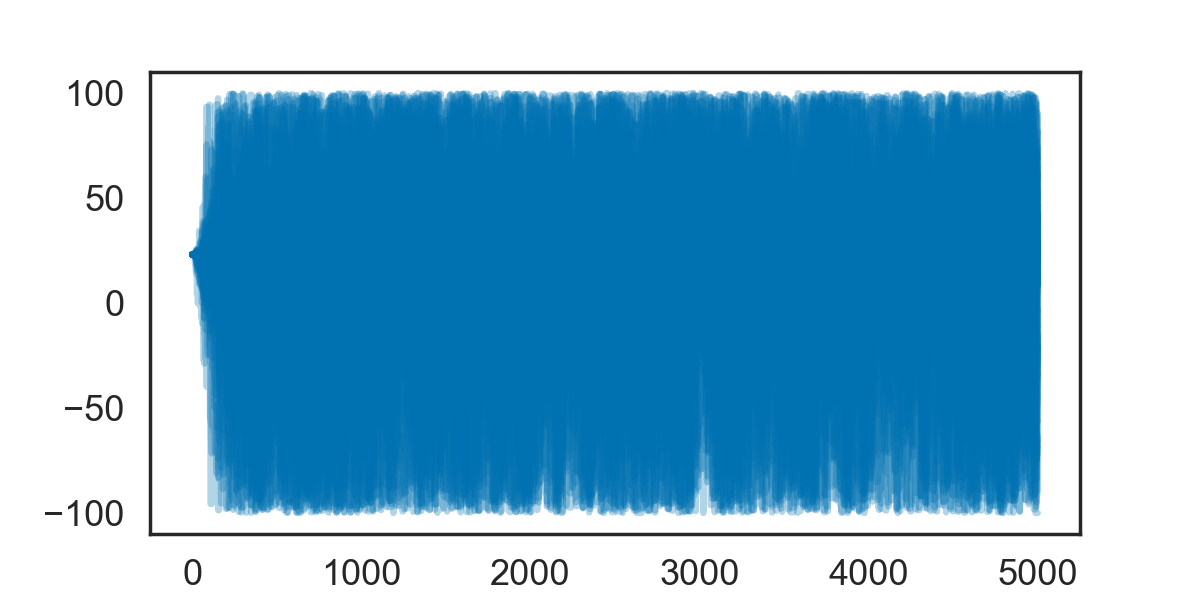

<IPython.core.display.Javascript object>


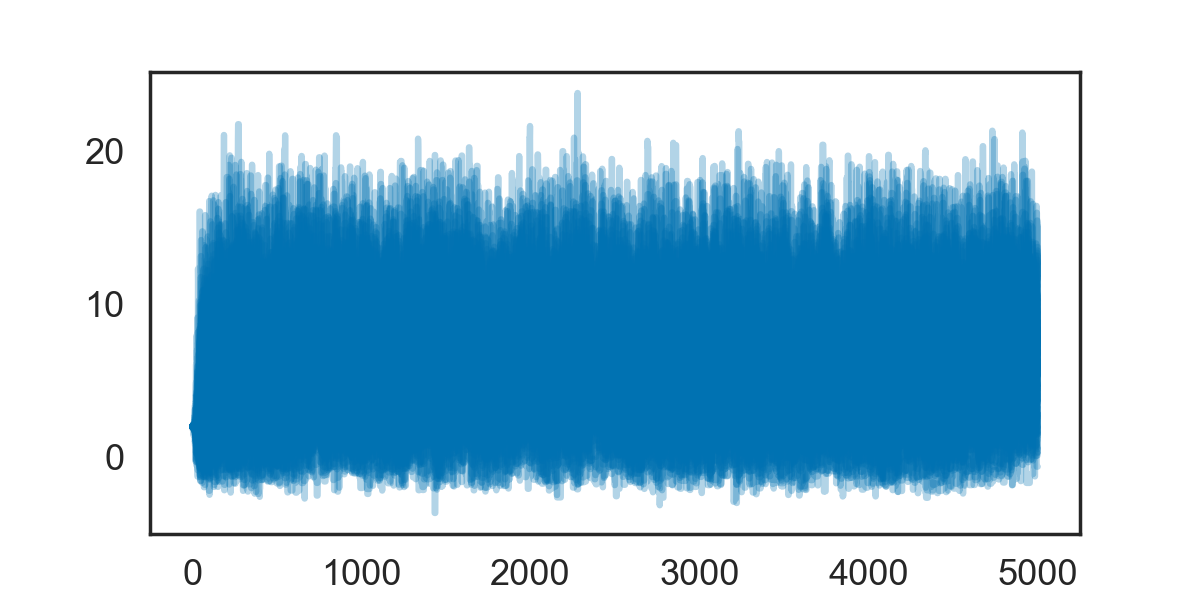

<IPython.core.display.Javascript object>


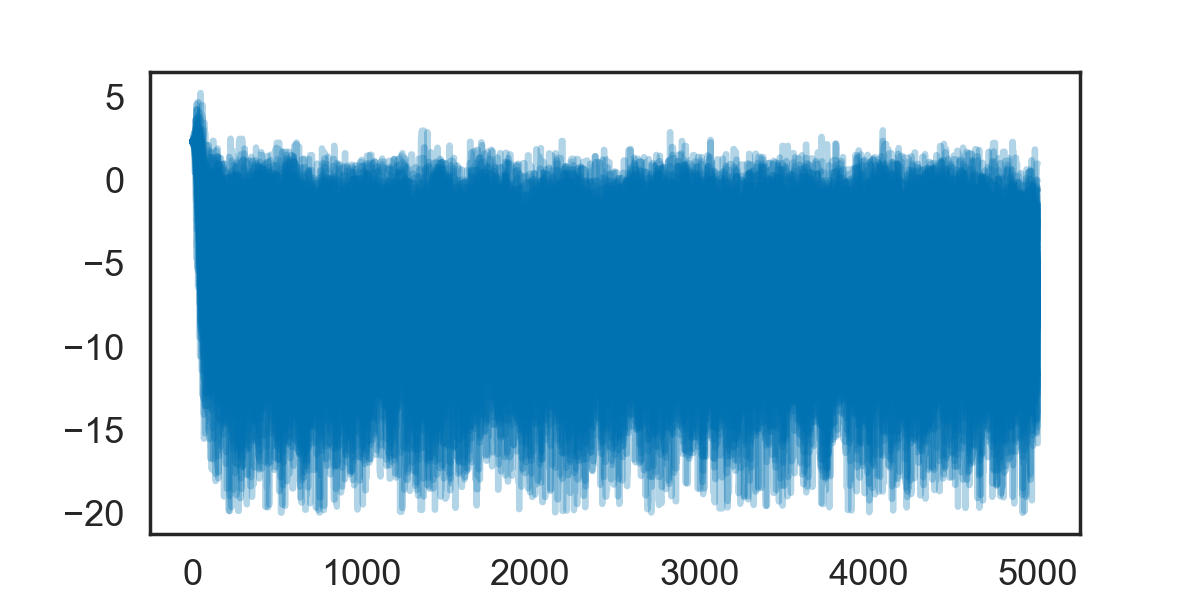

<IPython.core.display.Javascript object>


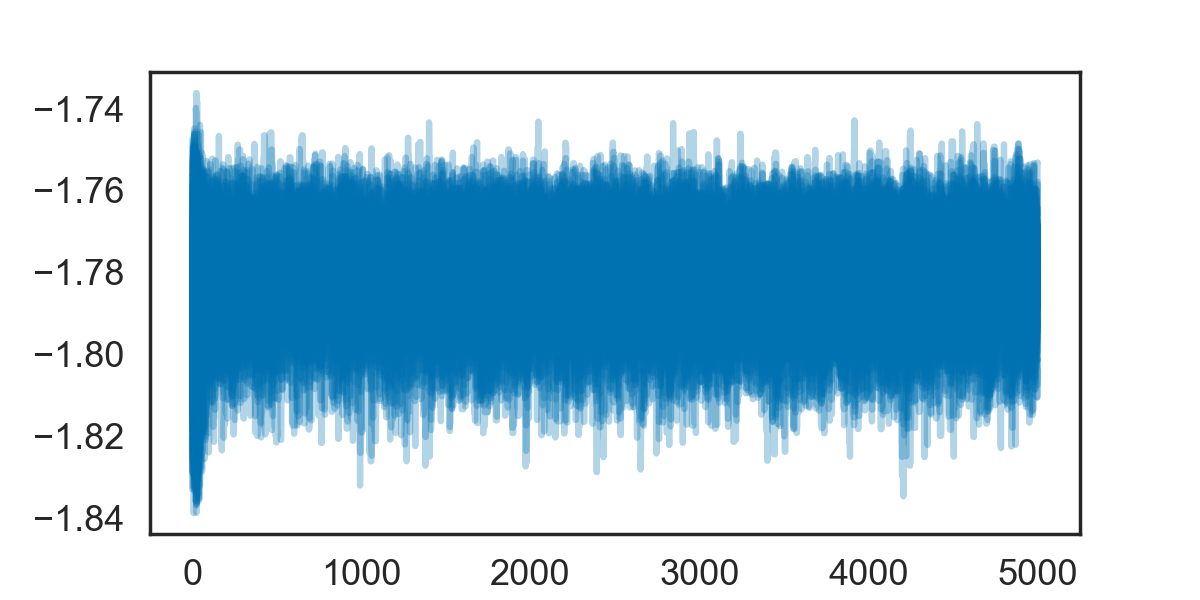

In [250]:
for i in range(ndim):
    fig, ax = plt.subplots(1, 1, figsize=(6,3))
    ax.plot(sampler.chain[:,:,i].T, color=sns.color_palette()[0], alpha=0.3)

In [251]:
import corner

In [252]:
flatchain = np.concatenate(sampler.chain[:,-500:,:], axis=0)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


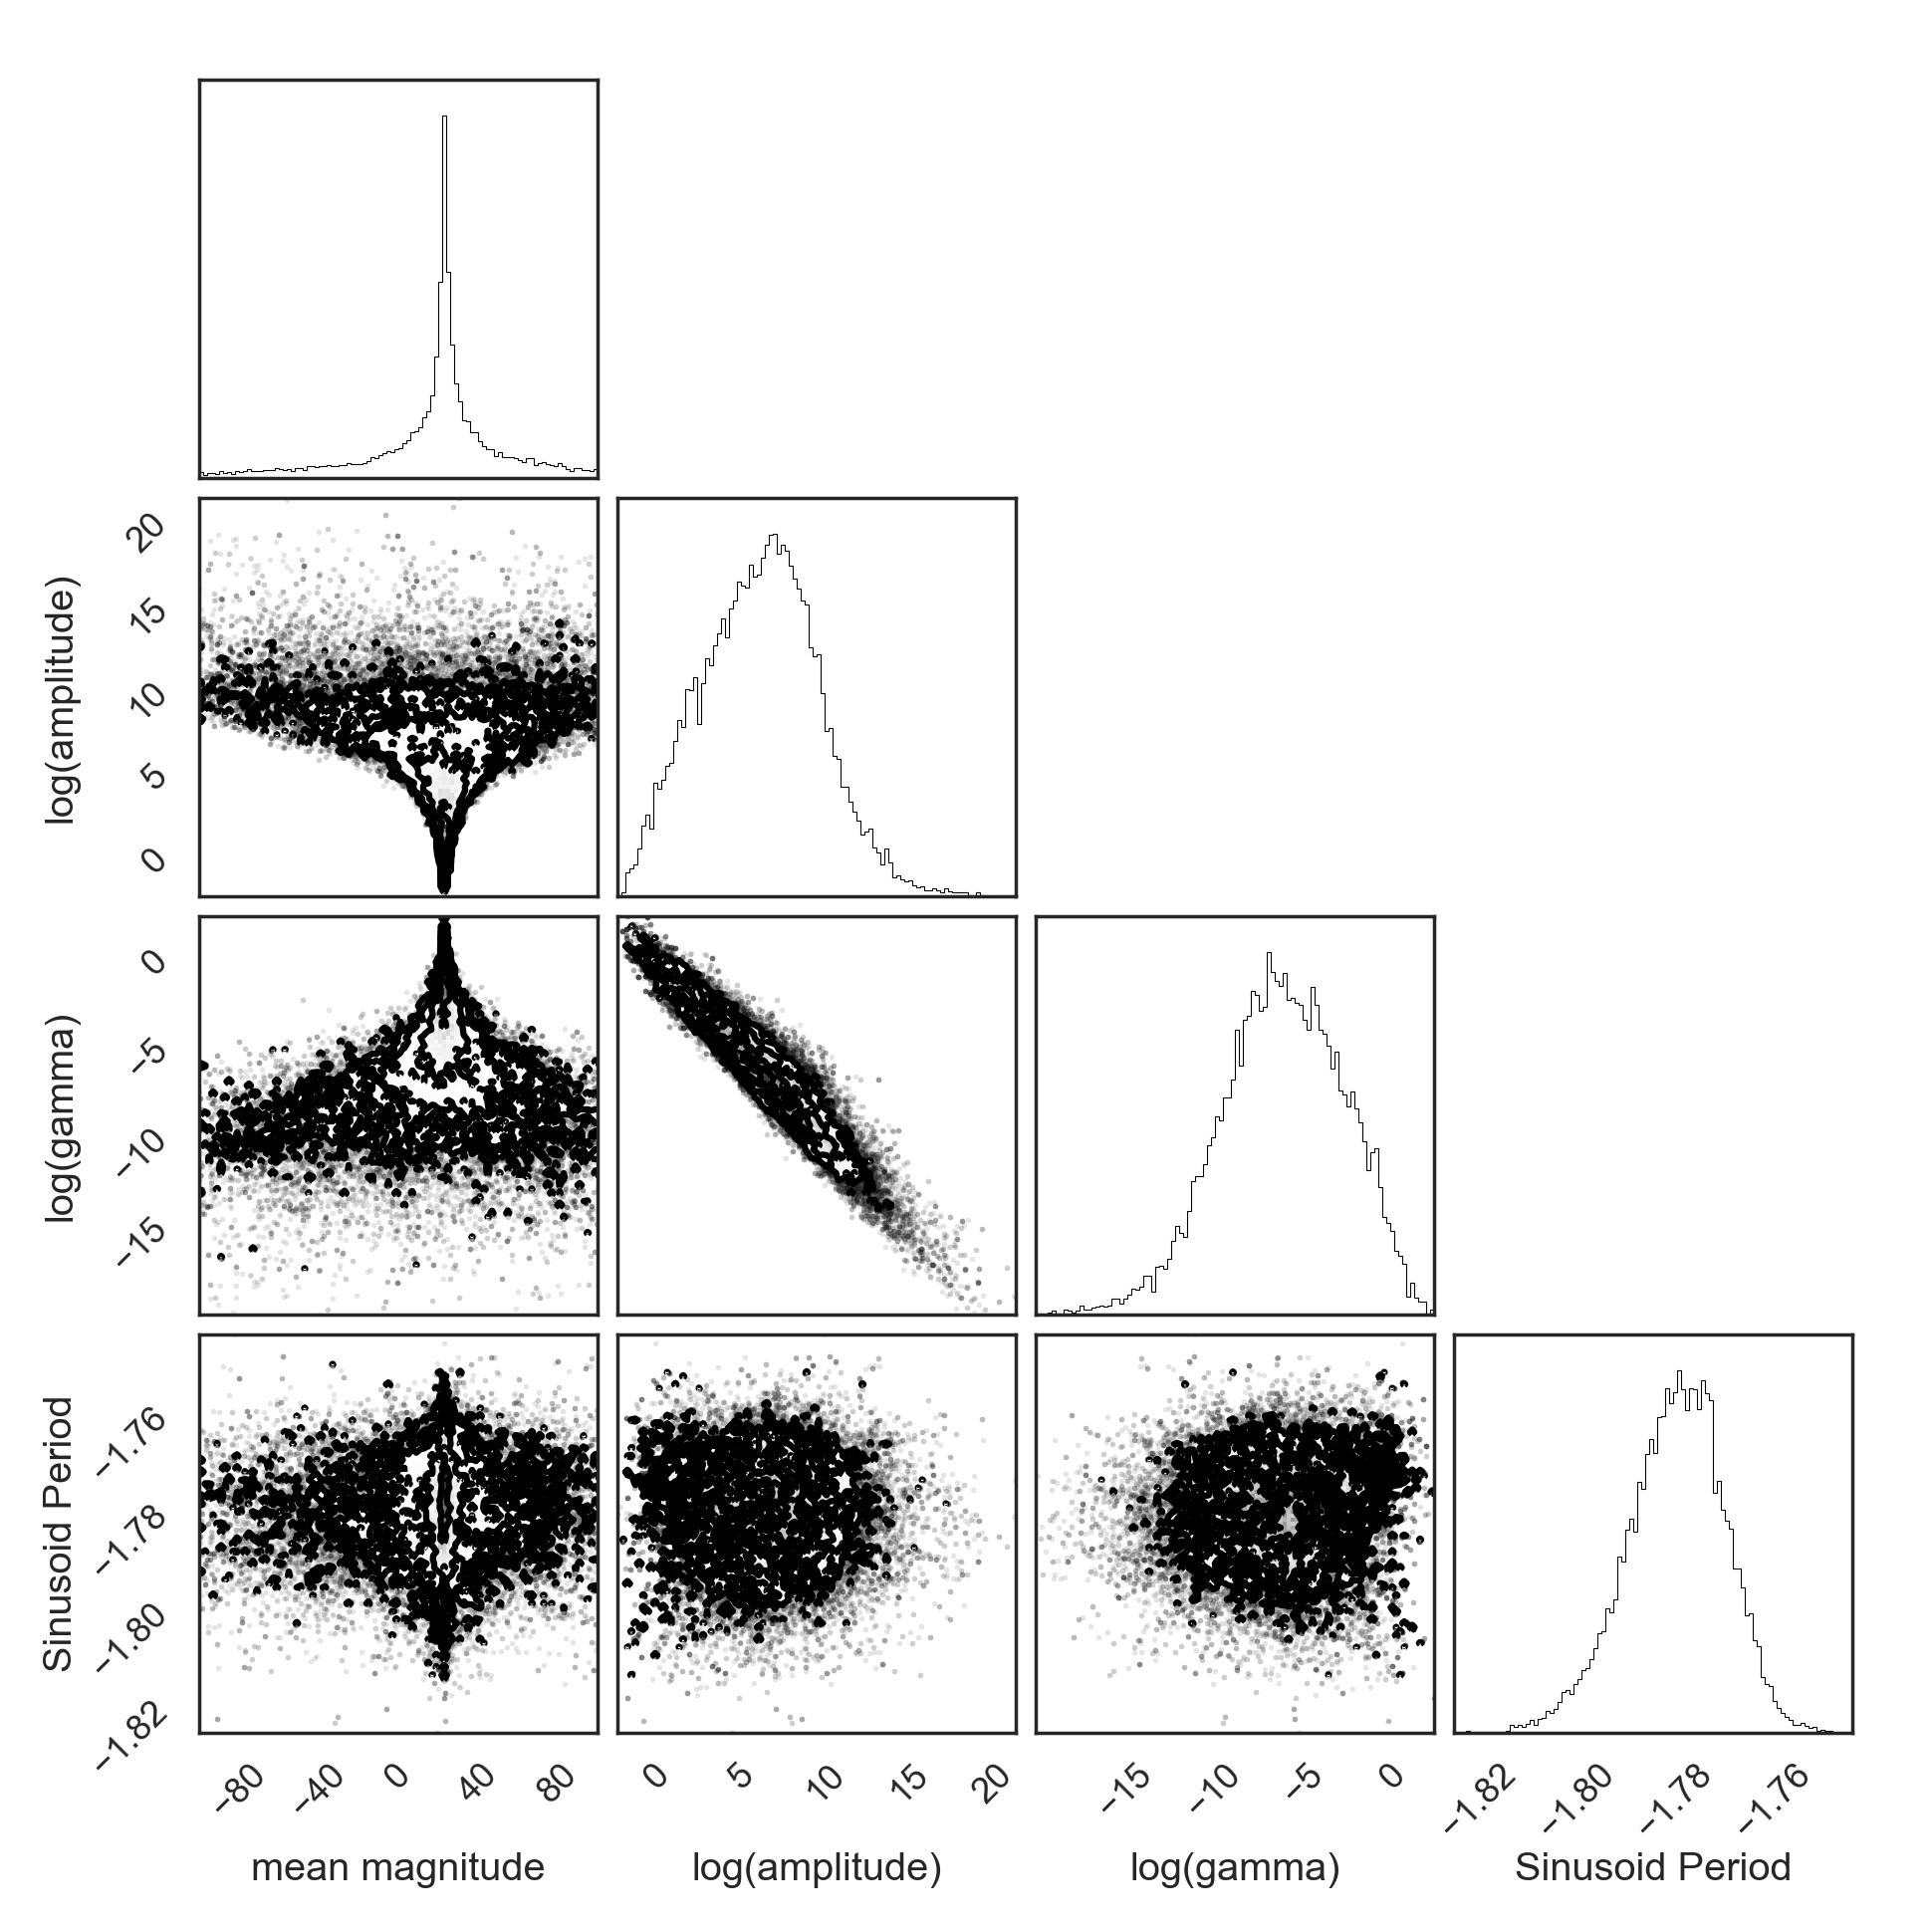

In [253]:
corner.corner(flatchain, labels=["mean magnitude", "log(amplitude)", "log(gamma)", "Sinusoid Period"], bins=100);

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


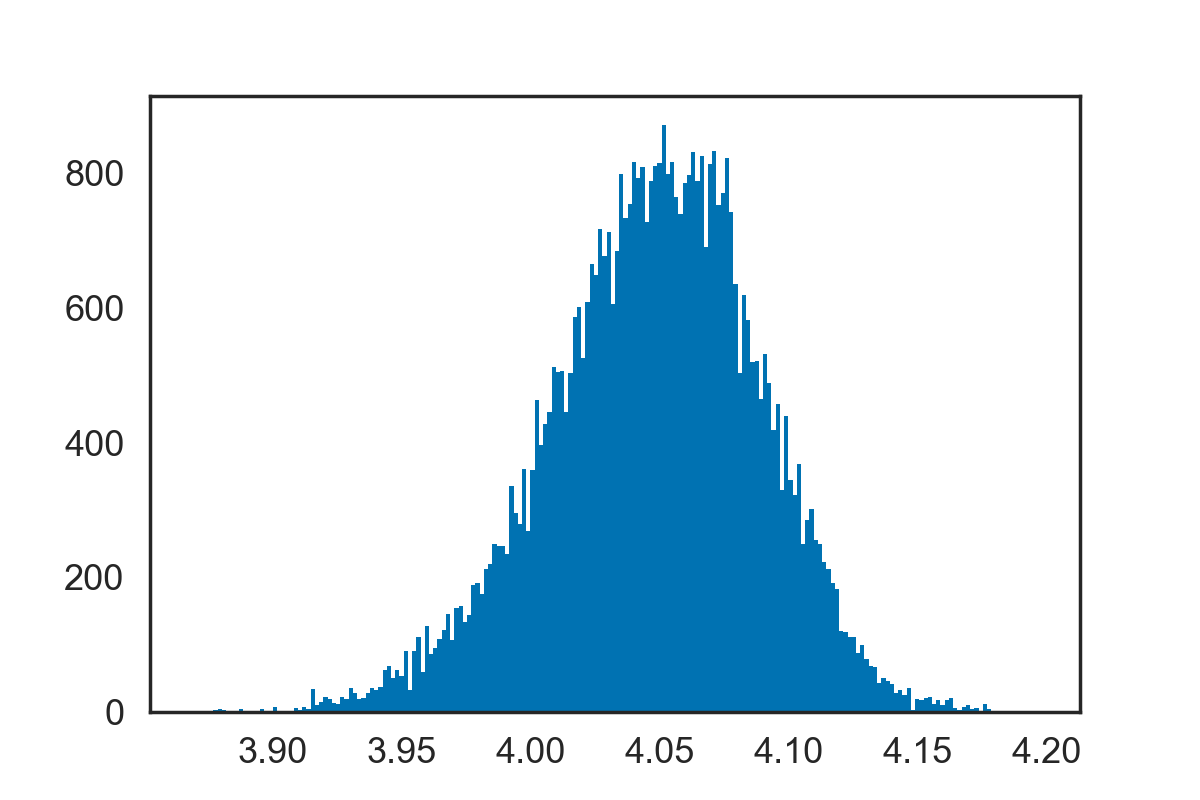

In [283]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(f, bins=200, histtype="stepfilled");

In [257]:
f = flatchain[:,-1]

In [261]:
w = np.where(sampler.lnprobability == np.max(sampler.lnprobability))

In [262]:
max_ind = [w[0][0], w[1][0]]

-19.5552147969


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


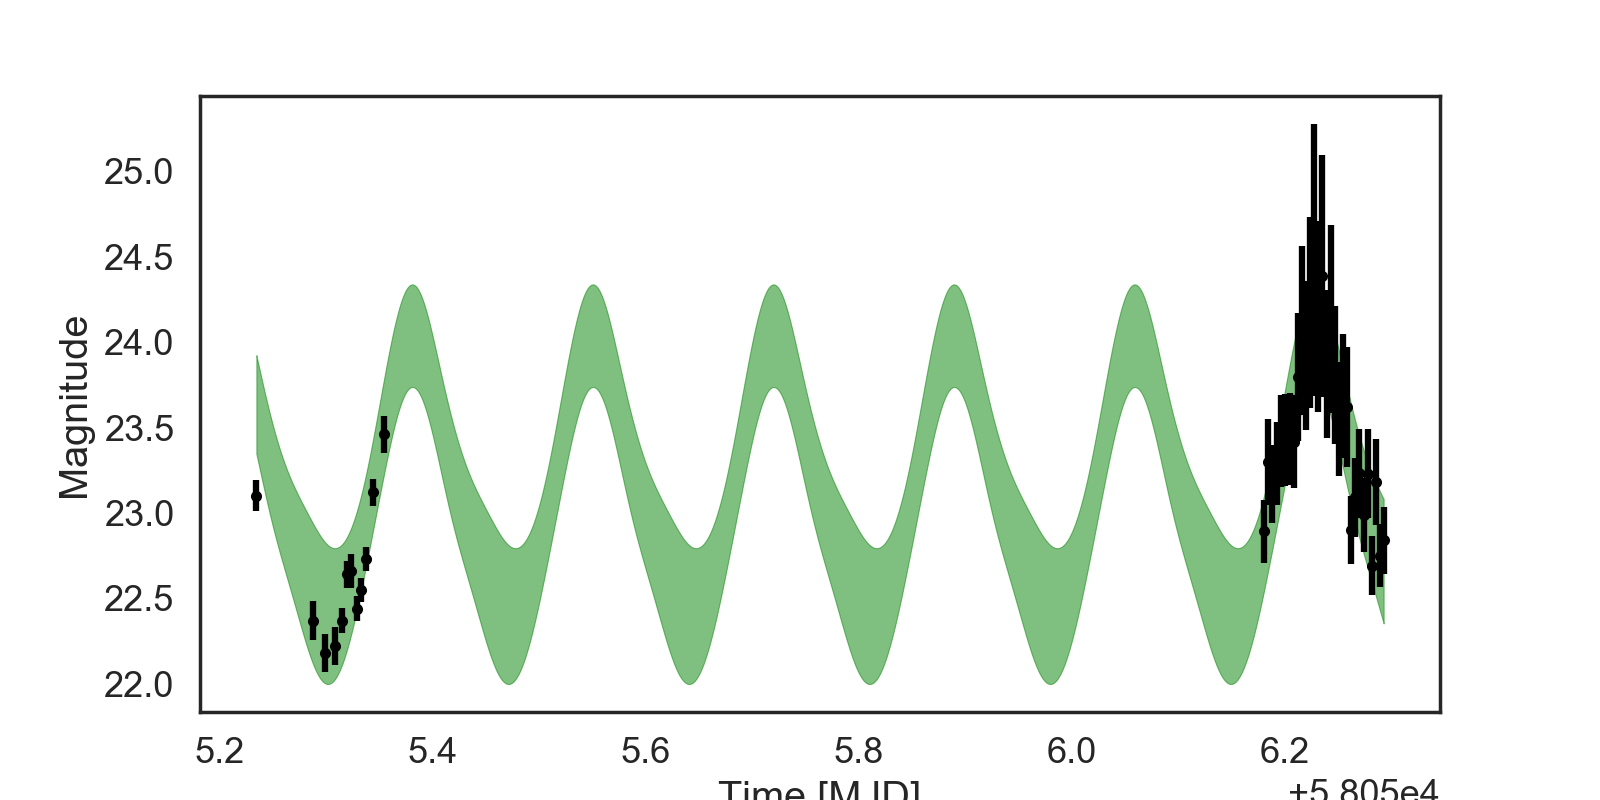

In [263]:
max_pars = sampler.chain[max_ind[0], max_ind[1], :]
# Update the kernel and print the final log-likelihood.
max_pars = [max_pars[0], max_pars[1], np.exp(max_pars[2]), max_pars[3]]

gp.set_parameter_vector(max_pars)
print(gp.log_likelihood(mag))

x = np.linspace(np.min(time), np.max(time), 5000)
mu, var = gp.predict(mag, x, return_var=True)
std = np.sqrt(var)

plt.figure(figsize=(8,4))
plt.errorbar(time, mag, yerr=data["mag_err"],
             color="black", fmt="o", markersize=4)
plt.fill_between(x, mu+2*std, mu-2*std, color="g", alpha=0.5)

plt.xlabel("Time [MJD]")
plt.ylabel("Magnitude");

What is the prediction if the period is twice as long?

In [264]:
new_period = np.exp(max_pars[-1])*2

In [265]:
new_pars = [max_pars[0], max_pars[1], np.exp(max_pars[2]), np.log(new_period)]

In [266]:
flatchain[:,-1] = np.exp(flatchain[:, -1])

In [267]:
flatchain[:,-1] = flatchain[:,-1]*24.0

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


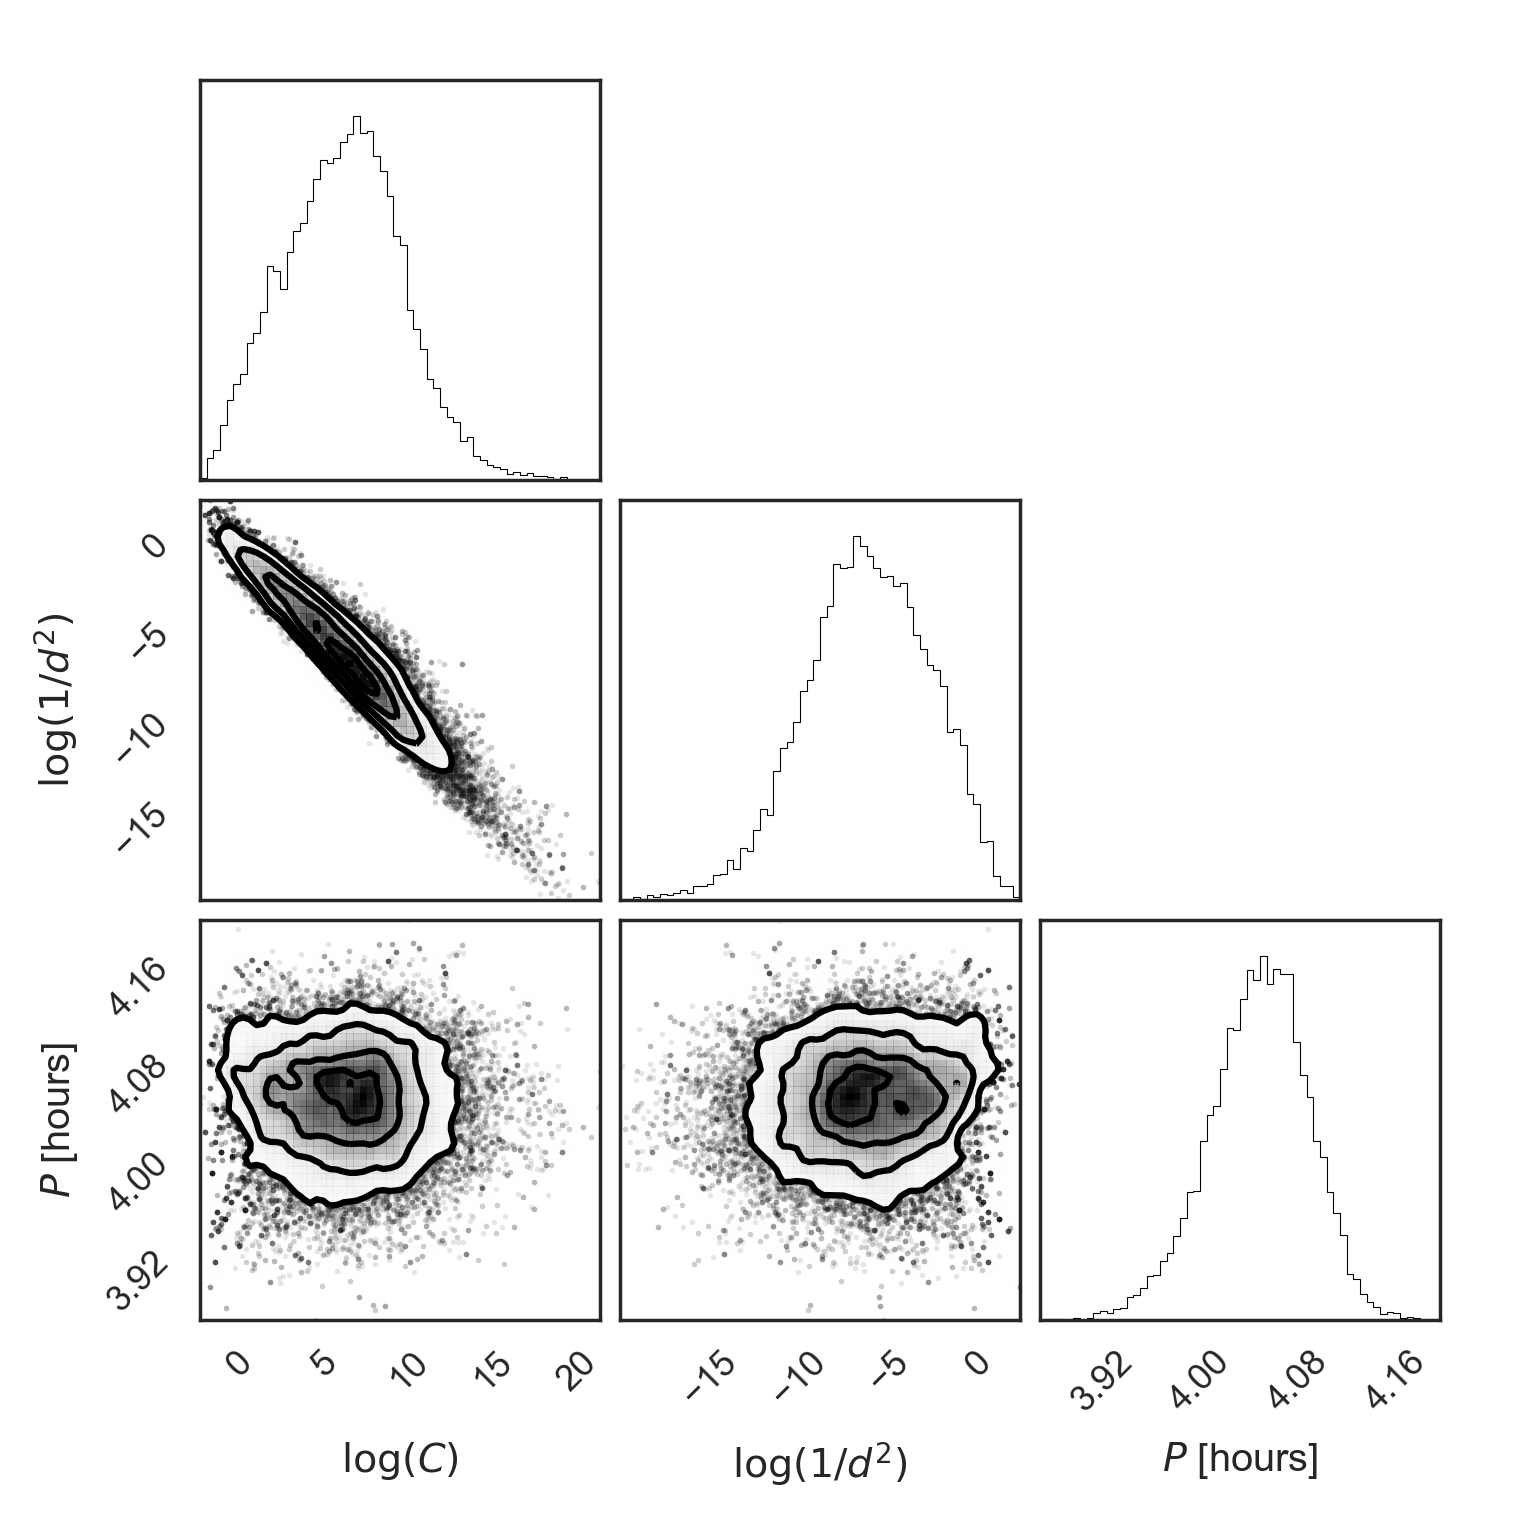

In [271]:
fig = corner.corner(flatchain[:,1:], labels=["$\log(C)$", r"$\log(1/d^2)$", "$P$ [hours]"], bins=60, smooth=1);
axes = fig.get_axes()
plt.savefig("comet_gp_corner.eps", format="eps", frameon=True)

In [272]:
np.mean(f)

4.0477002752916977

In [273]:
np.percentile(f, [50-68.27/2.0, 50, 50+68.27/2.], axis=0)

array([ 4.00761398,  4.0498404 ,  4.08771717])

In [274]:
4.048004667630849 - 4.00921917

0.038785497630849264

In [275]:
4.08785865 - 4.048004667630849

0.039853982369151275

In [277]:
mind = time.searchsorted(58055.5)

-20.5580618089


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


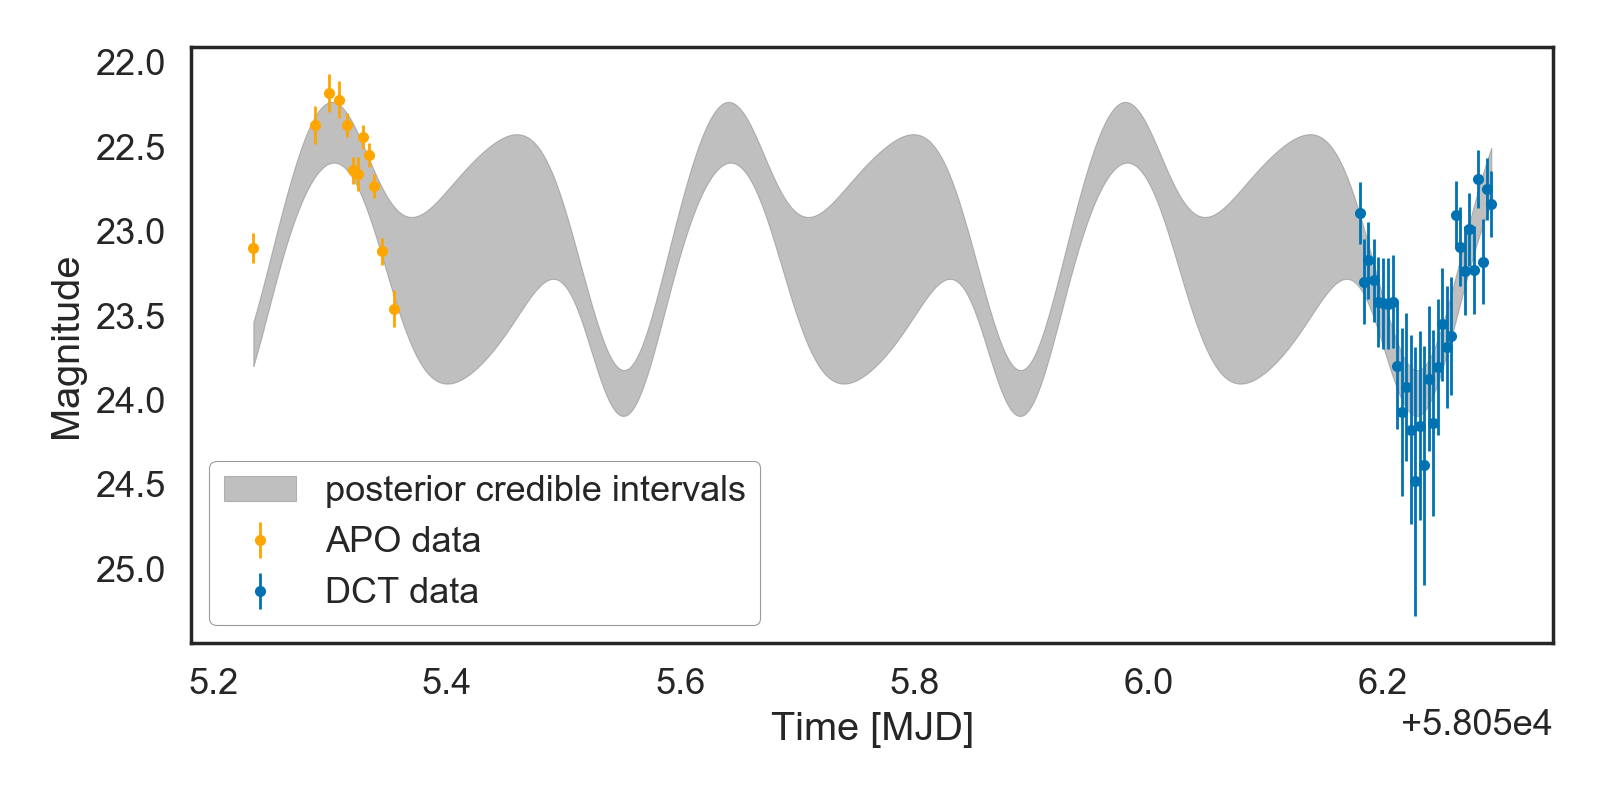

In [279]:
gp.set_parameter_vector(new_pars)
print(gp.log_likelihood(mag))

x = np.linspace(np.min(time), np.max(time), 5000)
mu, var = gp.predict(mag, x, return_var=True)
std = np.sqrt(var)

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.errorbar(time[:mind], mag[:mind], yerr=mag_err[:mind],lw=1,
             color="orange", fmt="o", markersize=4, label="APO data")

ax.errorbar(time[mind:], mag[mind:], yerr=mag_err[mind:],lw=1, label="DCT data",
             color=sns.color_palette()[0], fmt="o", markersize=4)


ax.fill_between(x, mu+std, mu-std, color="grey", alpha=0.5, label="posterior credible intervals")

leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('grey')

ax.set_xlabel("Time [MJD]")
ax.set_ylabel("Magnitude");
ax.set_ylim(ax.get_ylim()[::-1])

plt.tight_layout()
plt.savefig("comet_gp_2periods.pdf", format="pdf")